# **Mini Project 2 Done by: Rahma Nouaji,  Mohammad Ghavidel, Bita Farokhian**

---



# Task 1: Dataset preprocessing

Import libraries


In [ ]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf


Load the CIFAR-10 dataset




In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Exploring the dataset


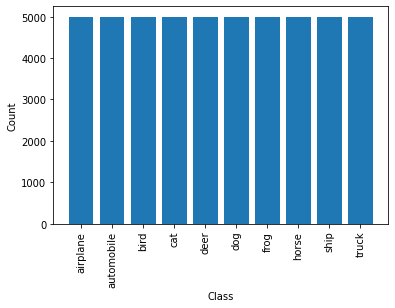

In [ ]:
##Class Distribution
# Count the number of images in each class
unique, counts = np.unique(y_train, return_counts=True)
class_count = dict(zip(unique, counts))

# Plot a bar chart of the class distribution
plt.bar(class_count.keys(), class_count.values())
plt.xticks(range(10), ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], rotation=90)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [ ]:
print("Shape of training data:")
print(x_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(x_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


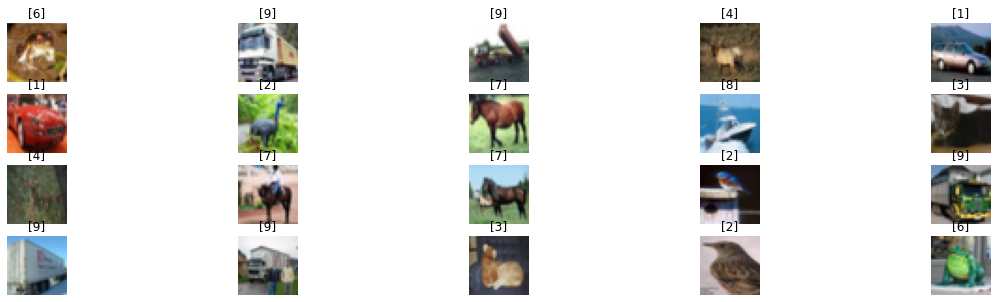

In [ ]:
# Plot the first 20 images from the training set
fig, axes = plt.subplots(4, 5, figsize=(20, 5))
axes = axes.ravel()
for i in range(20):
    axes[i].imshow(x_train[i])
    axes[i].set_title(y_train[i])
    axes[i].axis('off')
plt.show()

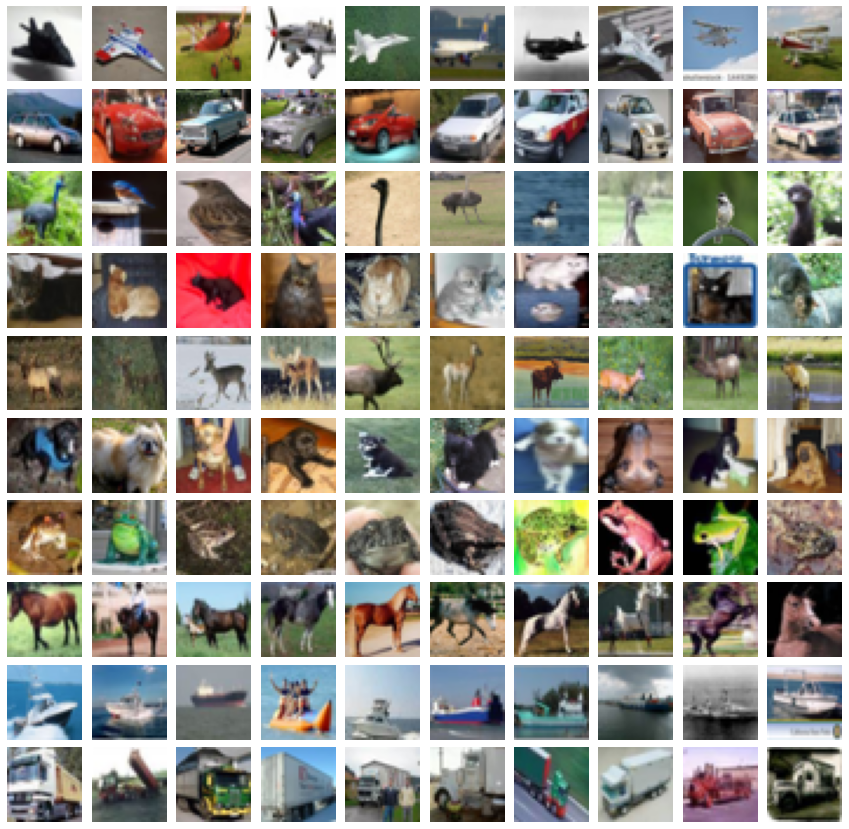

In [ ]:
# Display the first 10 images from each class
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15,15))
for i in range(10):
    images = x_train[y_train.flatten() == i][:10]
    for j in range(10):
        axes[i][j].imshow(images[j])
        axes[i][j].axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

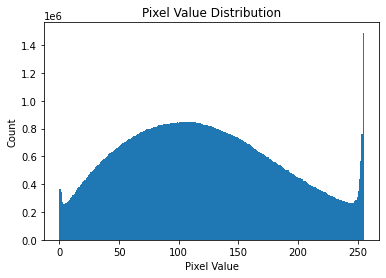

In [ ]:
# Flatten the images and plot a histogram of the pixel values
pixels = x_train.flatten()
plt.hist(pixels, bins=256, range=(0,255))
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.show()



> The resulting chart shows a roughly uniform distribution of pixel values between 0 and 255, indicating that the images in the dataset are not too bright or too dark.



Preprocessing of the Dataset

In [ ]:
# Transform label indices to one-hot encoded vectors

#y_train = to_categorical(y_train, num_classes=10)
#y_test = to_categorical(y_test, num_classes=10)

# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)

#X_train = np.reshape(x_train,(50000,3072))
#X_test = np.reshape(x_test,(10000,3072))
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')

In [ ]:


# Compute mean and standard deviation of the pixel values
mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))

# Transform label indices to one-hot encoded vectors

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Center and normalize the data
x_train = (x_train )/255
x_test = (x_test )/255

# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)

X_train = np.reshape(x_train,(50000,3072))
X_test = np.reshape(x_test,(10000,3072))

#Task 2: MLP model

In [ ]:
#Activation functions Tanh
def tanh(x):
 y= 2/(1 + np.exp(-2*x)) - 1
 return y
#activation_tanh = {(lambda x: np.tanh(x))}
deriv_tanh = {(lambda x: 1-x**2)}
#Activation function ReLU
activation_ReLU = {(lambda x: x*(x > 0))}
deriv_ReLU = {(lambda x: 1 * (x>0))}
#Activation function leaky ReLU
leaky_Relu= {(lambda x: x*0.01 if x < 0 else x)}
derive_leaky_Relu= {(lambda x: 0.01 if x < 0 else 1)}
#Activation function Sigmoid
activation_sigmoid= {(lambda x: 1 / (1 + np.exp(-x)))}
##Derivative sigmoid
def derivative_sigmoid(x):
        s = activation_sigmoid(x)
        return s * (1 - s)
activation_softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0,keepdims=True)

deriv_softmax = lambda x: np.diag(activation_softmax(x)) - np.outer(activation_softmax(x), activation_softmax(x))


In [ ]:
class Layer:
    def __init__(self, units=None, input_units=None, activation=None, l2_regularization=0):
            self.input_units = input_units
            self.output_units = units
            self.regularization = l2_regularization
            assert activation in [None,'tanh','leaky_relu','relu','sigmoid','softmax'], 'Activation not recognized'
            self.activation = activation

class Model:
    def __init__(self, layers, batch_size,lr,max_norm=None,random_state=21):

        np.random.seed(random_state)
        self.batch_size=batch_size
        self.lr=lr
        self.parameters = {}
        self.activations = {}
        self.gradients = {}
        self.max_norm=max_norm
        self.regularization ={}
        self.cache = {}
        self.X = None
        self.Y = None
        self.cost_train=[]
        self.cost_vali=[]
        self.train_accuracy = []
        self.val_accuracy = []

        self.L = len(layers)

        for l in range(1,self.L+1):

            layer = layers[l-1]

            if layer.input_units:
                input_units = layer.input_units
                output_units = layer.output_units
            else:
                input_units  = previous_output_units
                output_units = layer.output_units

            # Apply Xavier Initialization
            #xavier_stddev = np.sqrt(2 / (input_units + output_units))
            self.parameters['W' + str(l)] = np.random.randn(output_units,input_units) * np.sqrt(2./input_units)
            self.parameters['b' + str(l)] = np.zeros((layer.output_units,1))

            self.activations['a' + str(l)] = layer.activation
            self.regularization['r' + str(l)] = layer.regularization

            previous_output_units = layer.output_units

    def forward(self, X):
      A_prev = X
      for l in range(1, self.L+1):
        Wl = self.parameters['W' + str(l)]
        bl = self.parameters['b' + str(l)]
        activation_fn = self.activations['a' + str(l)]

        Zl = np.dot(Wl, A_prev) + bl
        if activation_fn == 'tanh':
            Al = tanh(Zl)
        elif activation_fn == 'relu':
            Al = np.maximum(0, Zl)
        elif activation_fn == 'sigmoid':
            Al = 1 / (1 + np.exp(-Zl))
        elif activation_fn == 'softmax':
            exp_Zl = np.exp(Zl)
            Al = exp_Zl / np.sum(exp_Zl, axis=0, keepdims=True)
        elif activation_fn == 'leaky_relu':
            Al = np.maximum(0.01 * Zl, Zl)

        self.cache['Z' + str(l)] = Zl
        self.cache['A' + str(l)] = Al

        A_prev = Al

      return Al




    def loss(self, AL, Y):
        m = Y.shape[1]
        cost=0


        loss_each_example = -np.sum(Y * np.log(AL),axis=1)
        all_losses = np.sum(loss_each_example)
        cost = all_losses/m
        return cost
    def accuracy(self, A, Y):
        # calculate accuracy here

        predictions = np.argmax(A, axis=0)
        labels = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == labels)
        return accuracy

    def backward(self):
      m = self.X.shape[1] # number of examples

      # Retrieve all weights, biases, activations, and regularization parameters
      W, b, a, r = {}, {}, {}, {}
      A, Z = {}, {}
      for l in range(1, self.L+1):
          W[l] = self.parameters['W' + str(l)]
          b[l] = self.parameters['b' + str(l)]
          a[l] = self.activations['a' + str(l)]
          r[l] = self.regularization['r' + str(l)]

          A[l] = self.cache['A' + str(l)]
          Z[l] = self.cache['Z' + str(l)]
      A[0] = self.X

      # Backward propagation: calculate dW1, db1, ..., dWL, dbL
      dW, db, dZ = {}, {}, {}
      for l in reversed(range(1, self.L+1)):
          if a[l] == 'sigmoid' or a[l] == 'softmax':
              dZ[l] = A[l] - self.Y
          elif a[l] == 'tanh':
              dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (1 - np.square(Z[l])))
          elif a[l] == 'relu':
              dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (Z[l] > 0))
          elif a[l] == 'leaky_relu':
            dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (Z[l] > 0) + (Z[l] <= 0) * 0.01)
          dW[l] = np.dot(dZ[l], A[l-1].T) / m
          db[l] = np.sum(dZ[l], axis=1, keepdims=True) / m
         # if self.max_norm:
          #  for l in reversed(range(1, self.L+1)):
           #   dW[l] = np.clip(dW[l], a_min=-self.max_norm, a_max=self.max_norm)
            #  db[l] = np.clip(db[l], a_min=-self.max_norm, a_max=self.max_norm)

      # Update weights and biases using gradient descent
      for l in range(1, self.L+1):
          W[l] -= self.lr * dW[l]
          b[l] -= self.lr * db[l]
          self.parameters['W' + str(l)] = W[l]
          self.parameters['b' + str(l)] = b[l]


    def get_batch(self, X, Y):

        np.random.seed(1)
        m = X.shape[1]
        mini_batches = []

        #shuffling the data
        permutation = list(np.random.permutation(X.shape[1]))
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[:, permutation]
        num_of_complete_batches = m // self.batch_size
        for i in range(num_of_complete_batches):
            mini_batch_X = X_shuffled[:,i* self.batch_size:(i+1)* self.batch_size]
            mini_batch_Y = Y_shuffled[:,i* self.batch_size:(i+1)* self.batch_size]
            mini_batch = (mini_batch_X,mini_batch_Y)
            mini_batches.append(mini_batch)

        #if there is incomplete batch
        if m % self.batch_size!= 0:

            mini_batch_X=X_shuffled[:,num_of_complete_batches* self.batch_size:num_of_complete_batches* self.batch_size + (m - self.batch_size *num_of_complete_batches)]
            mini_batch_Y=Y_shuffled[:,num_of_complete_batches* self.batch_size:num_of_complete_batches* self.batch_size + (m - self.batch_size *num_of_complete_batches)]
            mini_batch = (mini_batch_X,mini_batch_Y)
            mini_batches.append(mini_batch)
        return mini_batches


    def fit(self,
            X,
            Y,
            validation_data=None,
            epochs=100,
            patience=None):

        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values
        if isinstance(Y, (pd.core.frame.DataFrame,pd.core.series.Series)):
            Y = Y.values

        if X.ndim > 1:
            X = X.T
        else:
            X = np.expand_dims(X, axis=1)

        if Y.ndim > 1:
            Y = Y.T
        else:
            Y = np.expand_dims(Y, axis=0)

        self.full_Y = Y
        self.full_X = X

        mini_batches = self.get_batch(X, Y)

        if validation_data:
            X_val, Y_val = validation_data

            if isinstance(X_val, pd.core.frame.DataFrame):
                X_val = X_val.values
            if isinstance(Y_val, (pd.core.frame.DataFrame,pd.core.series.Series)):
                Y_val = Y_val.values

            if X_val.ndim > 1:
                X_val = X_val.T
            else:
                X_val = np.expand_dims(X_val, axis=1)

            if Y_val.ndim > 1:
                Y_val = Y_val.T
            else:
                Y_val = np.expand_dims(Y_val, axis=0)

        if patience:
            epoch_cache ={}
        cost_train=[]
        cost_vali=[]
        for i in range(0, epochs):

            for mini_batch in mini_batches:

                mini_batch_X, mini_batch_Y = mini_batch

                self.X = mini_batch_X
                self.Y = mini_batch_Y

                AL = self.forward(mini_batch_X)
                cost = self.loss(AL, mini_batch_Y)
                train_acc = self.accuracy(AL, mini_batch_Y)



                self.backward()

            if validation_data:
                AL_val = self.forward(X_val)
                cost_val = self.loss(AL_val, Y_val)

            # Print the cost and acc every epoch
            if validation_data:
                train_acc = self.accuracy(AL, mini_batch_Y)
                val_acc = self.accuracy(AL_val, Y_val)
                self.val_accuracy.append(val_acc)
                print(f"Epoch {i+1} - Train_Loss:{cost}  Val_Loss:{cost_val} Train_Acc:{train_acc} Val_Acc:{val_acc}")
                self.cost_train.append(cost)
                self.train_accuracy.append(train_acc)
                self.cost_vali.append(cost_val)

            else:

                self.cost_train.append(cost)
                print(f"Epoch {i+1} - Train_Loss:{cost}")

            if patience:
               if not epoch_cache or cost_val <= epoch_cache['best_loss']:
                    epoch_cache['best_loss'] = cost_val
                    epoch_cache['best_parameters'] = self.parameters
                    counter=0
               elif cost_val > epoch_cache['best_loss']:
                    counter += 1

               if counter == patience:
                    self.parameters = epoch_cache['best_parameters']
                    print(f"Early Stopping! Best Epoch {i+1-patience} - Val_Loss:{epoch_cache['best_loss']}")
                    break


    def predict(self, X):

        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values

        if X.ndim > 1:
            X = X.T
        else:
            X = np.expand_dims(X, axis=1)

        AL = self.forward(X)

        if AL.shape[0]==1:
            y_pred = AL[0]>0.5
        else:
            y_pred = (AL == np.max(AL,axis=0)).astype(bool).T
        y_pred = y_pred*1
        y_pred. astype('float32')
        return y_pred


    def get_cost(self,validation=True):
      if validation:
          return self.cost_train,self.cost_vali
      else:
        return self.cost_train
    def score(self,validation=True):
      if validation:
        return self.train_accuracy, self.val_accuracy
      else:
        return self.train_accuracy

def evaluate_acc(y, y_pred):
  acc=np.mean(np.argmax(y, axis=1) == np.argmax(y_pred, axis=1))
  print('The evaluation accuracy is ', acc)

In [ ]:
# tran val split 25%
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,random_state=1,test_size=0.25)


In [ ]:
paramters=[Layer(units=256,input_units=3072, activation='relu'),
               Layer(units=64, activation='relu'),
               Layer(units=10, activation='softmax')]
model = Model(paramters, batch_size=64,lr=0.001,
               random_state=4)

In [ ]:
model.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),
          epochs=30)

Epoch 1 - Train_Loss:1.5086176701014982  Val_Loss:1.6349388121757908 Train_Acc:0.375 Val_Acc:0.4204
Epoch 2 - Train_Loss:1.4424172654828091  Val_Loss:1.5991352549427182 Train_Acc:0.375 Val_Acc:0.43368
Epoch 3 - Train_Loss:1.3849953623581317  Val_Loss:1.5688091675393312 Train_Acc:0.375 Val_Acc:0.44544
Epoch 4 - Train_Loss:1.3257857466746557  Val_Loss:1.5421544154314073 Train_Acc:0.4375 Val_Acc:0.4556
Epoch 5 - Train_Loss:1.27407150619436  Val_Loss:1.5181682818093678 Train_Acc:0.5625 Val_Acc:0.46624
Epoch 6 - Train_Loss:1.2233842451283194  Val_Loss:1.4967694044647224 Train_Acc:0.5625 Val_Acc:0.47504
Epoch 7 - Train_Loss:1.1848212487333842  Val_Loss:1.4770043930658587 Train_Acc:0.6875 Val_Acc:0.48144
Epoch 8 - Train_Loss:1.1498387091931512  Val_Loss:1.4587914317081883 Train_Acc:0.6875 Val_Acc:0.48936
Epoch 9 - Train_Loss:1.1167463298369493  Val_Loss:1.4417271085180328 Train_Acc:0.6875 Val_Acc:0.49576
Epoch 10 - Train_Loss:1.0854254125496332  Val_Loss:1.4257054013230168 Train_Acc:0.6875 Va

In [ ]:
plt.plot(model.get_cost()[0],label='Training Loss')
plt.plot(model.get_cost()[1],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
plt.plot(model.score()[0],label='Training acc')
plt.plot(model.score()[1],label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
pred = np.where(model.predict(X_test)==1)[1]
test = np.where(y_test==1)[1]
print(classification_report(test,pred,digits=4))

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
evaluate_acc(y_test,y_pred)

##Gridsearch cross validation from scratch

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
parameters=[Layer(units=256,input_units=3072, activation='relu'),
               Layer(units=256, activation='relu'),
               Layer(units=10, activation='softmax')]
def train_evaluate_model(params, X_train, y_train, X_val, y_val, num_epochs=30,patience=5):
    model = Model(layers=parameters, lr=params['lr'],
                  batch_size=params['batch_size'], random_state=1)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs)
    val_error =model.get_cost()[1]
    return val_error


# Define hyperparameters and their possible values
params_grid = {

    'lr': [0.001, 0.01, 0.1],
    'batch_size': [128, 64, 32],
}

# Define number of folds for cross-validation
num_folds = 5

# Create list of hyperparameter combinations to test
param_combinations = []

for lr in params_grid['lr']:
    for batch_size in params_grid['batch_size']:
            params = { 'lr': lr, 'batch_size': batch_size}
            param_combinations.append(params)



In [ ]:
# Perform cross-validation on each set of hyperparameters
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
results = {}
for params in param_combinations:
    val_errors = []
    for train_idx, val_idx in kf.split(X_train):
        # split data into training and validation sets for current fold
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]

        # train and evaluate model on current fold
        val_error = train_evaluate_model(params, X_train_fold, y_train_fold, X_val_fold, y_val_fold)

        # append validation accuracy to list of validation accuracies for this set of hyperparameters
        val_errors.append(val_error)
     # calculate mean and standard deviation of validation accuracies for this set of hyperparameters
    mean_val_error = np.mean(val_errors)
    std_val_error = np.std(val_errors)

    # print results for this set of hyperparameters
    print("Validation error for this set of hyperparameters {param} is {valerror}".format(param=params,valerror= val_errors))
    print("Mean validation error for this set of hyperparameters {param} is {meanval}".format(param=params,meanval= mean_val_error))
    print("Standard deviation of validation error for this set of hyperparameters {param} is {stderr}".format(param=params,stderr= std_val_error))

    # update dictionary of results with mean validation accuracy for this set of hyperparameters
    results[str(params)] = [mean_val_error,std_val_error]

# print final results
print("Final results:", results)

Epoch 1 - Train_Loss:2.1601709023602806  Val_Loss:2.1715255002278555 Train_Acc:0.23 Val_Acc:0.2174222222222222
Epoch 2 - Train_Loss:2.0937489784315173  Val_Loss:2.0930140284566296 Train_Acc:0.26 Val_Acc:0.2551111111111111
Epoch 3 - Train_Loss:2.0498073607801492  Val_Loss:2.0429527070054725 Train_Acc:0.25 Val_Acc:0.2702222222222222
Epoch 4 - Train_Loss:2.0171094735285937  Val_Loss:2.0065481428020706 Train_Acc:0.26 Val_Acc:0.2840888888888889
Epoch 5 - Train_Loss:1.9914126420391032  Val_Loss:1.9781015792467178 Train_Acc:0.28 Val_Acc:0.2986666666666667
Epoch 6 - Train_Loss:1.9715510791038495  Val_Loss:1.953773161512935 Train_Acc:0.31 Val_Acc:0.3112888888888889
Epoch 7 - Train_Loss:1.9531576881591177  Val_Loss:1.9343440055541234 Train_Acc:0.33 Val_Acc:0.3232
Epoch 8 - Train_Loss:1.9383014164565515  Val_Loss:1.917698776223044 Train_Acc:0.35 Val_Acc:0.3304888888888889
Epoch 9 - Train_Loss:1.925180971219898  Val_Loss:1.903185705418606 Train_Acc:0.36 Val_Acc:0.3340444444444444
Epoch 10 - Train_

In [ ]:
#results= {"{'lr': 0.001, 'batch_size': 128}": [1.8796730562788306, 0.09944853792979212], "{'lr': 0.001, 'batch_size': 64}": [1.7998515756756002, 0.09945365315766191], "{'lr': 0.001, 'batch_size': 32}": [1.732251848092999, 0.10083217523854918], "{'lr': 0.01, 'batch_size': 128}": [1.6327004204378697, 0.10586798932949268], "{'lr': 0.01, 'batch_size': 64}": [1.6112549625284995, 0.1025109540314804], "{'lr': 0.01, 'batch_size': 32}": [1.7039695269572208, 0.1674026532482218], "{'lr': 0.1, 'batch_size': 128}": [1.6795054702972405, 0.10283320410060352], "{'lr': 0.1, 'batch_size': 64}": [1.76709603969979, 0.13654029209921129], "{'lr': 0.1, 'batch_size': 32}": [2.0538286117707774, 0.30143014484522224]}


In [ ]:
import pandas as pd
# Data is the same as final results
# Create another dictionary from the final result dictionary


# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(results, orient='index', columns=['Mean val error', 'Std of val error'])

# Extract the hyperparameters from the index
df.index = df.index.map(eval)

# Reset the index to create separate columns for the hyperparameters
df = df.reset_index().rename(columns={'index': 'Hyperparameters'})

# Print the resulting DataFrame
print(df)

                    Hyperparameters  Mean val error  Std of val error
0  {'lr': 0.001, 'batch_size': 128}        1.879673          0.099449
1   {'lr': 0.001, 'batch_size': 64}        1.799852          0.099454
2   {'lr': 0.001, 'batch_size': 32}        1.732252          0.100832
3   {'lr': 0.01, 'batch_size': 128}        1.632700          0.105868
4    {'lr': 0.01, 'batch_size': 64}        1.611255          0.102511
5    {'lr': 0.01, 'batch_size': 32}        1.703970          0.167403
6    {'lr': 0.1, 'batch_size': 128}        1.679505          0.102833
7     {'lr': 0.1, 'batch_size': 64}        1.767096          0.136540
8     {'lr': 0.1, 'batch_size': 32}        2.053829          0.301430


In [ ]:
# Find the row with the minimum loss
min_std_row = df.loc[df['Std of val error'].idxmin()]
min_mean_row = df.loc[df['Mean val error'].idxmin()]
# Get the corresponding hyperparameters
hyperparams = min_std_row['Hyperparameters']
hyperparams = min_mean_row['Hyperparameters']
# Print the hyperparameters
print('The hyperparameters that give the lowest std are ',hyperparams)
print('The hyperparameters that give the lowest mean are ',hyperparams)


The hyperparameters that give the lowest std are  {'lr': 0.01, 'batch_size': 64}
The hyperparameters that give the lowest mean are  {'lr': 0.01, 'batch_size': 64}


# Task 3: Run the experiments

## Task 3.1: Three MLP Models

In [ ]:
##We added early stopping to prevent the model from overfitting which is enabled with the parameter patience

The patience parameter determines the number of epochs to wait before stopping training if there is no improvement in the validation loss. The implementation keeps track of the best loss and parameters using a cache, and if the current validation loss is better than the previous best, it updates the cache and resets the counter. If the validation loss is worse than the previous best, it increments the counter.

Once the counter reaches the patience value, the implementation rolls back to the best parameters and stops the training loop. It also prints out the best epoch and validation loss for reference.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,random_state=1,test_size=0.25)


### First Model: Input to Ouput

In [ ]:
Inp_out_layer_paramters=[Layer(units=10,input_units=3072, activation='softmax')]
model1 = Model(Inp_out_layer_paramters, batch_size=64,lr=0.01,
               random_state=4)



In [ ]:
model1.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),patience=5,
          epochs=30)

Epoch 1 - Train_Loss:1.8740524477183202  Val_Loss:1.887190445174737 Train_Acc:0.31666666666666665 Val_Acc:0.33896
Epoch 2 - Train_Loss:1.8466456960554425  Val_Loss:1.8401623823121924 Train_Acc:0.3333333333333333 Val_Acc:0.356
Epoch 3 - Train_Loss:1.8305257290399168  Val_Loss:1.817664839435775 Train_Acc:0.3333333333333333 Val_Acc:0.36448
Epoch 4 - Train_Loss:1.818886365714929  Val_Loss:1.8035585865871884 Train_Acc:0.35 Val_Acc:0.37056
Epoch 5 - Train_Loss:1.8099088862378423  Val_Loss:1.7935232512193648 Train_Acc:0.3333333333333333 Val_Acc:0.37392
Epoch 6 - Train_Loss:1.802764249757213  Val_Loss:1.7858571333554858 Train_Acc:0.3333333333333333 Val_Acc:0.37608
Epoch 7 - Train_Loss:1.7969754334088954  Val_Loss:1.7797368650230925 Train_Acc:0.3333333333333333 Val_Acc:0.37936
Epoch 8 - Train_Loss:1.792221946598955  Val_Loss:1.7747045021827041 Train_Acc:0.3333333333333333 Val_Acc:0.38136
Epoch 9 - Train_Loss:1.788270882889692  Val_Loss:1.7704784098349913 Train_Acc:0.35 Val_Acc:0.3824
Epoch 10 -

In [ ]:
pred1 = np.where(model1.predict(X_test)==1)[1]
test = np.where(y_test==1)[1]
print(classification_report(test,pred1,digits=4))

              precision    recall  f1-score   support

           0     0.5420    0.2450    0.3375      1000
           1     0.4097    0.5330    0.4633      1000
           2     0.3344    0.2190    0.2647      1000
           3     0.3341    0.1470    0.2042      1000
           4     0.3392    0.3670    0.3525      1000
           5     0.2953    0.3910    0.3365      1000
           6     0.4311    0.4910    0.4591      1000
           7     0.4644    0.4430    0.4534      1000
           8     0.3506    0.7300    0.4737      1000
           9     0.5289    0.3020    0.3845      1000

    accuracy                         0.3868     10000
   macro avg     0.4030    0.3868    0.3729     10000
weighted avg     0.4030    0.3868    0.3729     10000



In [ ]:
y_pred1=model1.predict(X_test)

In [ ]:
evaluate_acc(y_test,y_pred1)

The evaluation accuracy is  0.3868


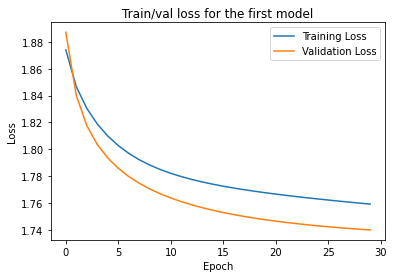

In [ ]:
plt.plot(model1.get_cost()[0],label='Training Loss')
plt.plot(model1.get_cost()[1],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/val loss for the first model')
plt.legend()
plt.show()


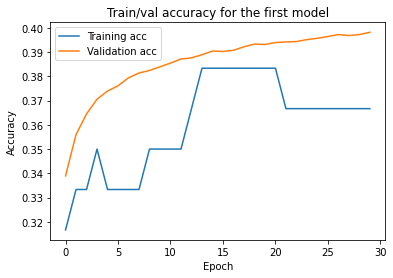

In [ ]:
plt.plot(model1.score()[0],label='Training acc')
plt.plot(model1.score()[1],label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/val accuracy for the first model')

plt.legend()
plt.show()



>First model is underfitting since it has a very high training error.



### Second Model: 1 hidden layer

In [ ]:
onehidden_layer_paramters=[Layer(units=256,input_units=3072, activation='relu'),
               Layer(units=10, activation='softmax')]
model2 = Model(onehidden_layer_paramters,  batch_size=64,lr=0.01,
               random_state=1)

In [ ]:
 model2.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),patience=5,

          epochs=30
    )

Epoch 1 - Train_Loss:1.7900615205396406  Val_Loss:1.8354165377451794 Train_Acc:0.3 Val_Acc:0.35272
Epoch 2 - Train_Loss:1.7121076379249416  Val_Loss:1.7501395568708016 Train_Acc:0.35 Val_Acc:0.38872
Epoch 3 - Train_Loss:1.6578715439940974  Val_Loss:1.6950266098773223 Train_Acc:0.38333333333333336 Val_Acc:0.40704
Epoch 4 - Train_Loss:1.6170139893646573  Val_Loss:1.6562079738904225 Train_Acc:0.38333333333333336 Val_Acc:0.41896
Epoch 5 - Train_Loss:1.5736229720989756  Val_Loss:1.628174130717208 Train_Acc:0.4 Val_Acc:0.42648
Epoch 6 - Train_Loss:1.5561441769126865  Val_Loss:1.6053392664934196 Train_Acc:0.4 Val_Acc:0.43424
Epoch 7 - Train_Loss:1.5311965882946064  Val_Loss:1.5863089190537116 Train_Acc:0.45 Val_Acc:0.4416
Epoch 8 - Train_Loss:1.4997999076740243  Val_Loss:1.5686360824540957 Train_Acc:0.48333333333333334 Val_Acc:0.44696
Epoch 9 - Train_Loss:1.4760114962366333  Val_Loss:1.5546116128509713 Train_Acc:0.4666666666666667 Val_Acc:0.45064
Epoch 10 - Train_Loss:1.4528358723792223  Val_

In [ ]:
pred = np.where(model2.predict(X_test)==1)[1]
test = np.where(y_test==1)[1]
print(classification_report(test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.5787    0.5330    0.5549      1000
           1     0.5707    0.6780    0.6197      1000
           2     0.4378    0.2850    0.3452      1000
           3     0.3910    0.2960    0.3369      1000
           4     0.4191    0.4740    0.4449      1000
           5     0.3601    0.4620    0.4047      1000
           6     0.5268    0.6290    0.5734      1000
           7     0.6823    0.4210    0.5207      1000
           8     0.5134    0.7460    0.6082      1000
           9     0.5901    0.4750    0.5263      1000

    accuracy                         0.4999     10000
   macro avg     0.5070    0.4999    0.4935     10000
weighted avg     0.5070    0.4999    0.4935     10000



In [ ]:
y_pred=model2.predict(X_test)

In [ ]:
evaluate_acc(y_test,y_pred)

The evaluation accuracy is  0.4999


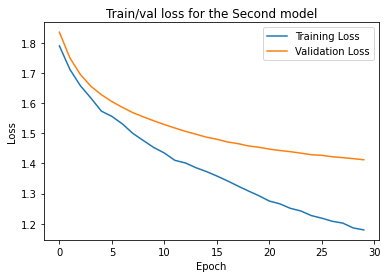

In [ ]:
plt.plot(model2.get_cost()[0],label='Training Loss')
plt.plot(model2.get_cost()[1],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/val loss for the Second model')
plt.legend()
plt.show()


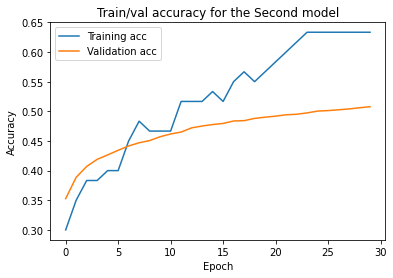

In [ ]:
plt.plot(model2.score()[0],label='Training acc')
plt.plot(model2.score()[1],label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/val accuracy for the Second model')

plt.legend()
plt.show()

### Third Model: 2 hidden layers

In [ ]:
twohidden_layer_parameters=[Layer(units=256,input_units=3072, activation='relu'),
               Layer(units=256, activation='relu'),
               Layer(units=10, activation='softmax')]
model3 = Model(twohidden_layer_parameters,  batch_size=64,lr=0.01,
               random_state=4)


In [ ]:
 model3.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),patience=5,

          epochs=30
          )

Epoch 1 - Train_Loss:1.7788094401332506  Val_Loss:1.8060182070565172 Train_Acc:0.35 Val_Acc:0.37184
Epoch 2 - Train_Loss:1.7098614107640355  Val_Loss:1.7223579258975086 Train_Acc:0.38333333333333336 Val_Acc:0.39712
Epoch 3 - Train_Loss:1.6494289521561252  Val_Loss:1.6651704643735692 Train_Acc:0.43333333333333335 Val_Acc:0.416
Epoch 4 - Train_Loss:1.5938497877548117  Val_Loss:1.6266076267051885 Train_Acc:0.4166666666666667 Val_Acc:0.42704
Epoch 5 - Train_Loss:1.5545498304292  Val_Loss:1.5958142482571058 Train_Acc:0.4666666666666667 Val_Acc:0.43704
Epoch 6 - Train_Loss:1.516107176574102  Val_Loss:1.5754671364153325 Train_Acc:0.4666666666666667 Val_Acc:0.44376
Epoch 7 - Train_Loss:1.4862802924039185  Val_Loss:1.5582544386043187 Train_Acc:0.4666666666666667 Val_Acc:0.44816
Epoch 8 - Train_Loss:1.4679848357112983  Val_Loss:1.5371865870215546 Train_Acc:0.4666666666666667 Val_Acc:0.45768
Epoch 9 - Train_Loss:1.4482649192056736  Val_Loss:1.5226323915722335 Train_Acc:0.4666666666666667 Val_Acc:

In [ ]:
pred = np.where(model3.predict(X_test)==1)[1]
test = np.where(y_test==1)[1]
print(classification_report(test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.6035    0.5190    0.5581      1000
           1     0.5754    0.6750    0.6213      1000
           2     0.4416    0.3330    0.3797      1000
           3     0.3599    0.3160    0.3365      1000
           4     0.4242    0.5040    0.4607      1000
           5     0.3932    0.4270    0.4094      1000
           6     0.4926    0.6290    0.5525      1000
           7     0.6961    0.4100    0.5160      1000
           8     0.5203    0.7430    0.6120      1000
           9     0.6167    0.4730    0.5354      1000

    accuracy                         0.5029     10000
   macro avg     0.5124    0.5029    0.4982     10000
weighted avg     0.5124    0.5029    0.4982     10000



In [ ]:
y_pred=model3.predict(X_test)

In [ ]:
evaluate_acc(y_test,y_pred)

The evaluation accuracy is  0.5029


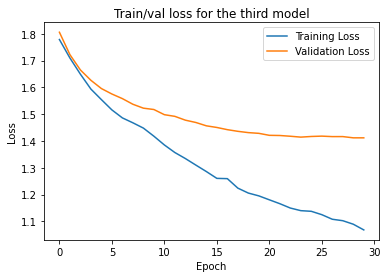

In [ ]:
plt.plot(model3.get_cost()[0],label='Training Loss')
plt.plot(model3.get_cost()[1],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/val loss for the third model')
plt.legend()
plt.show()


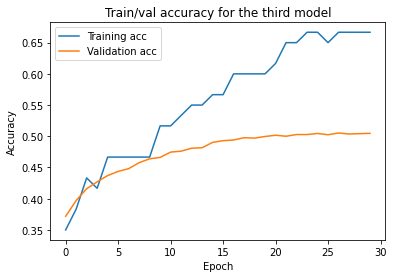

In [ ]:
plt.plot(model3.score()[0],label='Training acc')
plt.plot(model3.score()[1],label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/val accuracy for the third model')

plt.legend()
plt.show()

## Task 3.2: Leaky Relu and tanh activation function

### Leaky RelU activation function

In [ ]:
class Layer:
    def __init__(self, units=None, input_units=None, activation=None, l2_regularization=0):
            self.input_units = input_units
            self.output_units = units
            self.regularization = l2_regularization
            assert activation in [None,'tanh','leaky_relu','relu','sigmoid','softmax'], 'Activation not recognized'
            self.activation = activation

class Model:
    def __init__(self, layers, batch_size,lr,max_norm=None,random_state=21):

        np.random.seed(random_state)
        self.batch_size=batch_size
        self.lr=lr
        self.parameters = {}
        self.activations = {}
        self.gradients = {}
        self.max_norm=max_norm
        self.regularization ={}
        self.cache = {}
        self.X = None
        self.Y = None
        self.cost_train=[]
        self.cost_vali=[]
        self.train_accuracy = []
        self.val_accuracy = []

        self.L = len(layers)

        for l in range(1,self.L+1):

            layer = layers[l-1]

            if layer.input_units:
                input_units = layer.input_units
                output_units = layer.output_units
            else:
                input_units  = previous_output_units
                output_units = layer.output_units

            # Apply Xavier Initialization
            #xavier_stddev = np.sqrt(2 / (input_units + output_units))
            self.parameters['W' + str(l)] = np.random.randn(output_units,input_units) * np.sqrt(2./input_units)
            self.parameters['b' + str(l)] = np.zeros((layer.output_units,1))

            self.activations['a' + str(l)] = layer.activation
            self.regularization['r' + str(l)] = layer.regularization

            previous_output_units = layer.output_units

    def forward(self, X):
      A_prev = X
      for l in range(1, self.L+1):
        Wl = self.parameters['W' + str(l)]
        bl = self.parameters['b' + str(l)]
        activation_fn = self.activations['a' + str(l)]

        Zl = np.dot(Wl, A_prev) + bl
        if activation_fn == 'tanh':
            Al = tanh(Zl)
        elif activation_fn == 'relu':
            Al = np.maximum(0, Zl)
        elif activation_fn == 'sigmoid':
            Al = 1 / (1 + np.exp(-Zl))
        elif activation_fn == 'softmax':
            exp_Zl = np.exp(Zl)
            Al = exp_Zl / np.sum(exp_Zl, axis=0, keepdims=True)
        elif activation_fn == 'leaky_relu':
            Al = np.maximum(0.01 * Zl, Zl)

        self.cache['Z' + str(l)] = Zl
        self.cache['A' + str(l)] = Al

        A_prev = Al

      return Al




    def loss(self, AL, Y):
        m = Y.shape[1]
        cost=0


        loss_each_example = -np.sum(Y * np.log(AL),axis=1)
        all_losses = np.sum(loss_each_example)
        cost = all_losses/m
        return cost
    def accuracy(self, A, Y):
        # calculate accuracy here

        predictions = np.argmax(A, axis=0)
        labels = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == labels)
        return accuracy

    def backward(self):
      m = self.X.shape[1] # number of examples

      # Retrieve all weights, biases, activations, and regularization parameters
      W, b, a, r = {}, {}, {}, {}
      A, Z = {}, {}
      for l in range(1, self.L+1):
          W[l] = self.parameters['W' + str(l)]
          b[l] = self.parameters['b' + str(l)]
          a[l] = self.activations['a' + str(l)]
          r[l] = self.regularization['r' + str(l)]

          A[l] = self.cache['A' + str(l)]
          Z[l] = self.cache['Z' + str(l)]
      A[0] = self.X

      # Backward propagation: calculate dW1, db1, ..., dWL, dbL
      dW, db, dZ = {}, {}, {}
      for l in reversed(range(1, self.L+1)):
          if a[l] == 'sigmoid' or a[l] == 'softmax':
              dZ[l] = A[l] - self.Y
          elif a[l] == 'tanh':
              dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (1 - np.square(Z[l])))
          elif a[l] == 'relu':
              dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (Z[l] > 0))
          elif a[l] == 'leaky_relu':
            dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (Z[l] > 0) + (Z[l] <= 0) * 0.01)
          dW[l] = np.dot(dZ[l], A[l-1].T) / m
          db[l] = np.sum(dZ[l], axis=1, keepdims=True) / m
      if self.max_norm:
            for j in reversed(range(1, self.L+1)):
              dW[j] = np.clip(dW[j], a_min=-self.max_norm, a_max=self.max_norm)


      # Update weights and biases using gradient descent
      for l in range(1, self.L+1):
          W[l] -= self.lr * dW[l]
          b[l] -= self.lr * db[l]
          self.parameters['W' + str(l)] = W[l]
          self.parameters['b' + str(l)] = b[l]


    def get_batch(self, X, Y):

        np.random.seed(1)
        m = X.shape[1]
        mini_batches = []

        #shuffling the data
        permutation = list(np.random.permutation(X.shape[1]))
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[:, permutation]
        num_of_complete_batches = m // self.batch_size
        for i in range(num_of_complete_batches):
            mini_batch_X = X_shuffled[:,i* self.batch_size:(i+1)* self.batch_size]
            mini_batch_Y = Y_shuffled[:,i* self.batch_size:(i+1)* self.batch_size]
            mini_batch = (mini_batch_X,mini_batch_Y)
            mini_batches.append(mini_batch)

        #if there is incomplete batch
        if m % self.batch_size!= 0:

            mini_batch_X=X_shuffled[:,num_of_complete_batches* self.batch_size:num_of_complete_batches* self.batch_size + (m - self.batch_size *num_of_complete_batches)]
            mini_batch_Y=Y_shuffled[:,num_of_complete_batches* self.batch_size:num_of_complete_batches* self.batch_size + (m - self.batch_size *num_of_complete_batches)]
            mini_batch = (mini_batch_X,mini_batch_Y)
            mini_batches.append(mini_batch)
        return mini_batches


    def fit(self,
            X,
            Y,
            validation_data=None,
            epochs=100,
            patience=None):

        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values
        if isinstance(Y, (pd.core.frame.DataFrame,pd.core.series.Series)):
            Y = Y.values

        if X.ndim > 1:
            X = X.T
        else:
            X = np.expand_dims(X, axis=1)

        if Y.ndim > 1:
            Y = Y.T
        else:
            Y = np.expand_dims(Y, axis=0)

        self.full_Y = Y
        self.full_X = X

        mini_batches = self.get_batch(X, Y)

        if validation_data:
            X_val, Y_val = validation_data

            if isinstance(X_val, pd.core.frame.DataFrame):
                X_val = X_val.values
            if isinstance(Y_val, (pd.core.frame.DataFrame,pd.core.series.Series)):
                Y_val = Y_val.values

            if X_val.ndim > 1:
                X_val = X_val.T
            else:
                X_val = np.expand_dims(X_val, axis=1)

            if Y_val.ndim > 1:
                Y_val = Y_val.T
            else:
                Y_val = np.expand_dims(Y_val, axis=0)

        if patience:
            epoch_cache ={}
        cost_train=[]
        cost_vali=[]
        for i in range(0, epochs):

            for mini_batch in mini_batches:

                mini_batch_X, mini_batch_Y = mini_batch

                self.X = mini_batch_X
                self.Y = mini_batch_Y

                AL = self.forward(mini_batch_X)
                cost = self.loss(AL, mini_batch_Y)
                train_acc = self.accuracy(AL, mini_batch_Y)



                self.backward()

            if validation_data:
                AL_val = self.forward(X_val)
                cost_val = self.loss(AL_val, Y_val)

            # Print the cost and acc every epoch
            if validation_data:
                train_acc = self.accuracy(AL, mini_batch_Y)
                val_acc = self.accuracy(AL_val, Y_val)
                self.val_accuracy.append(val_acc)
                print(f"Epoch {i+1} - Train_Loss:{cost}  Val_Loss:{cost_val} Train_Acc:{train_acc} Val_Acc:{val_acc}")
                self.cost_train.append(cost)
                self.train_accuracy.append(train_acc)
                self.cost_vali.append(cost_val)

            else:

                self.cost_train.append(cost)
                print(f"Epoch {i+1} - Train_Loss:{cost}")

            if patience:
               if not epoch_cache or cost_val <= epoch_cache['best_loss']:
                    epoch_cache['best_loss'] = cost_val
                    epoch_cache['best_parameters'] = self.parameters
                    counter=0
               elif cost_val > epoch_cache['best_loss']:
                    counter += 1

               if counter == patience:
                    self.parameters = epoch_cache['best_parameters']
                    print(f"Early Stopping! Best Epoch {i+1-patience} - Val_Loss:{epoch_cache['best_loss']}")
                    break


    def predict(self, X):

        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values

        if X.ndim > 1:
            X = X.T
        else:
            X = np.expand_dims(X, axis=1)

        AL = self.forward(X)

        if AL.shape[0]==1:
            y_pred = AL[0]>0.5
        else:
            y_pred = (AL == np.max(AL,axis=0)).astype(bool).T
        y_pred = y_pred*1
        y_pred. astype('float32')
        return y_pred


    def get_cost(self,validation=True):
      if validation:
          return self.cost_train,self.cost_vali
      else:
        return self.cost_train
    def score(self,validation=True):
      if validation:
        return self.train_accuracy, self.val_accuracy
      else:
        return self.train_accuracy

def evaluate_acc(y, y_pred):
  acc=np.mean(np.argmax(y, axis=1) == np.argmax(y_pred, axis=1))
  print('The evaluation accuracy is ', acc)

In [ ]:
model3_leaky_relu= Model([Layer(units=256,input_units=3072, activation='leaky_relu'),
                Layer(units=256, activation='leaky_relu'),

               Layer(units=10, activation='softmax')],batch_size=64,lr=0.01,
               random_state=1)


In [ ]:
model3_leaky_relu.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),patience=5,

          epochs=30
          )

Epoch 1 - Train_Loss:1.5601130084677508  Val_Loss:1.6159563738627034 Train_Acc:0.43333333333333335 Val_Acc:0.43136
Epoch 2 - Train_Loss:1.4058789927529871  Val_Loss:1.536761041290531 Train_Acc:0.5 Val_Acc:0.46192
Epoch 3 - Train_Loss:1.3163451727024773  Val_Loss:1.4972128046011022 Train_Acc:0.55 Val_Acc:0.47472
Epoch 4 - Train_Loss:1.272158797926081  Val_Loss:1.4731619598745724 Train_Acc:0.5833333333333334 Val_Acc:0.48144
Epoch 5 - Train_Loss:1.2284264132227556  Val_Loss:1.4618323560498823 Train_Acc:0.5666666666666667 Val_Acc:0.48832
Epoch 6 - Train_Loss:1.1715915762686002  Val_Loss:1.4552526564493313 Train_Acc:0.65 Val_Acc:0.49224
Epoch 7 - Train_Loss:1.1128029461115132  Val_Loss:1.454795968259839 Train_Acc:0.6333333333333333 Val_Acc:0.49592
Epoch 8 - Train_Loss:1.0853443308448296  Val_Loss:1.4586306938667954 Train_Acc:0.6333333333333333 Val_Acc:0.50056
Epoch 9 - Train_Loss:1.0309870395096428  Val_Loss:1.4653328021834948 Train_Acc:0.65 Val_Acc:0.50248
Epoch 10 - Train_Loss:0.989131727

In [ ]:
y_pred=model3_leaky_relu.predict(X_test)

In [ ]:
evaluate_acc(y_test,y_pred)

The evaluation accuracy is  0.4956


In [ ]:
pred = np.where(model3_leaky_relu.predict(X_test)==1)[1]
test = np.where(y_test==1)[1]
print(classification_report(test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.6220    0.5100    0.5604      1000
           1     0.5691    0.6340    0.5998      1000
           2     0.4251    0.3720    0.3968      1000
           3     0.3557    0.3020    0.3267      1000
           4     0.4362    0.3860    0.4095      1000
           5     0.3540    0.5260    0.4232      1000
           6     0.5834    0.4720    0.5218      1000
           7     0.5575    0.5870    0.5718      1000
           8     0.5577    0.7060    0.6231      1000
           9     0.5469    0.4610    0.5003      1000

    accuracy                         0.4956     10000
   macro avg     0.5007    0.4956    0.4934     10000
weighted avg     0.5007    0.4956    0.4934     10000



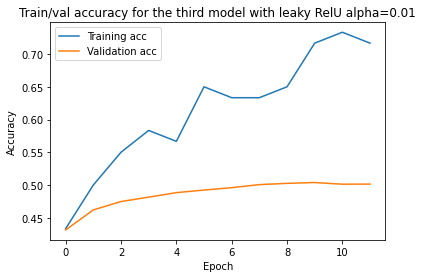

In [ ]:
plt.plot(model3_leaky_relu.score()[0],label='Training acc')
plt.plot(model3_leaky_relu.score()[1],label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/val accuracy for the third model with leaky RelU alpha=0.01')
plt.legend()
plt.show()

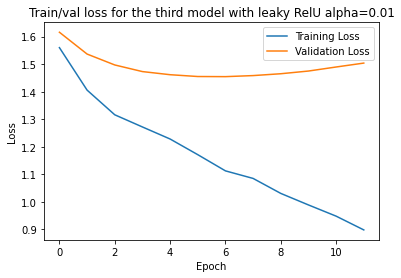

In [ ]:
plt.plot(model3_leaky_relu.get_cost()[0],label='Training Loss')
plt.plot(model3_leaky_relu.get_cost()[1],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/val loss for the third model with leaky RelU alpha=0.01')
plt.legend()
plt.show()

### Tanh Activation function

In [ ]:
model3_tanh = Model([Layer(units=256,input_units=3072, activation='tanh'),
                Layer(units=256, activation='tanh'),

               Layer(units=10, activation='softmax')],batch_size=64,lr=0.01,
               random_state=1)


In [ ]:
model3_tanh.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),

          epochs=30
          )

<ipython-input-119-f4a5f60f37fb>:2: RuntimeWarning: overflow encountered in exp
  y= 2/(1 + np.exp(-2*x)) - 1
<ipython-input-121-3a7cf72c7b2e>:120: RuntimeWarning: overflow encountered in square
  dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (1 - np.square(Z[l])))
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Epoch 1 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.11827956989247312 Val_Acc:0.09642666666666666
Epoch 2 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.11827956989247312 Val_Acc:0.09642666666666666
Epoch 3 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.11827956989247312 Val_Acc:0.09642666666666666
Epoch 4 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.11827956989247312 Val_Acc:0.09642666666666666
Epoch 5 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.11827956989247312 Val_Acc:0.09642666666666666
Epoch 6 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.11827956989247312 Val_Acc:0.09642666666666666
Epoch 7 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.11827956989247312 Val_Acc:0.09642666666666666
Epoch 8 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.11827956989247312 Val_Acc:0.09642666666666666
Epoch 9 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.11827956989247312 Val_Acc:0.09642666666666666
Epoch 10 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.11827956989247312 Val_Acc:0.09642666666666666
Epoch 11 - Train_Loss:nan  Va

KeyboardInterrupt: ignored

We wanted to try max norm to enforce an upper bound to the weights so they will not explode however we had the same problem of vanishing gradient descent with tanh.

In [ ]:
class Layer:
    def __init__(self, units=None, input_units=None, activation=None, l2_regularization=0):
            self.input_units = input_units
            self.output_units = units
            self.regularization = l2_regularization
            assert activation in [None,'tanh','leaky_relu','relu','sigmoid','softmax'], 'Activation not recognized'
            self.activation = activation

class Model:
    def __init__(self, layers, batch_size,lr,max_norm=None,random_state=21):

        np.random.seed(random_state)
        self.batch_size=batch_size
        self.lr=lr
        self.parameters = {}
        self.activations = {}
        self.gradients = {}
        self.max_norm=max_norm
        self.regularization ={}
        self.cache = {}
        self.X = None
        self.Y = None
        self.cost_train=[]
        self.cost_vali=[]
        self.train_accuracy = []
        self.val_accuracy = []

        self.L = len(layers)

        for l in range(1,self.L+1):

            layer = layers[l-1]

            if layer.input_units:
                input_units = layer.input_units
                output_units = layer.output_units
            else:
                input_units  = previous_output_units
                output_units = layer.output_units

            # Apply Xavier Initialization
            #xavier_stddev = np.sqrt(2 / (input_units + output_units))
            self.parameters['W' + str(l)] = np.random.randn(output_units,input_units) * np.sqrt(2./input_units)
            self.parameters['b' + str(l)] = np.zeros((layer.output_units,1))

            self.activations['a' + str(l)] = layer.activation
            self.regularization['r' + str(l)] = layer.regularization

            previous_output_units = layer.output_units

    def forward(self, X):
      A_prev = X
      for l in range(1, self.L+1):
        Wl = self.parameters['W' + str(l)]
        bl = self.parameters['b' + str(l)]
        activation_fn = self.activations['a' + str(l)]

        Zl = np.dot(Wl, A_prev) + bl
        if activation_fn == 'tanh':
            Al = tanh(Zl)
        elif activation_fn == 'relu':
            Al = np.maximum(0, Zl)
        elif activation_fn == 'sigmoid':
            Al = 1 / (1 + np.exp(-Zl))
        elif activation_fn == 'softmax':
            exp_Zl = np.exp(Zl)
            Al = exp_Zl / np.sum(exp_Zl, axis=0, keepdims=True)
        elif activation_fn == 'leaky_relu':
            Al = np.maximum(0.01 * Zl, Zl)

        self.cache['Z' + str(l)] = Zl
        self.cache['A' + str(l)] = Al

        A_prev = Al

      return Al




    def loss(self, AL, Y):
        m = Y.shape[1]
        cost=0


        loss_each_example = -np.sum(Y * np.log(AL),axis=1)
        all_losses = np.sum(loss_each_example)
        cost = all_losses/m
        return cost
    def accuracy(self, A, Y):
        # calculate accuracy here

        predictions = np.argmax(A, axis=0)
        labels = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == labels)
        return accuracy

    def backward(self):
      m = self.X.shape[1] # number of examples

      # Retrieve all weights, biases, activations, and regularization parameters
      W, b, a, r = {}, {}, {}, {}
      A, Z = {}, {}
      for l in range(1, self.L+1):
          W[l] = self.parameters['W' + str(l)]
          b[l] = self.parameters['b' + str(l)]
          a[l] = self.activations['a' + str(l)]
          r[l] = self.regularization['r' + str(l)]

          A[l] = self.cache['A' + str(l)]
          Z[l] = self.cache['Z' + str(l)]
      A[0] = self.X

      # Backward propagation: calculate dW1, db1, ..., dWL, dbL
      dW, db, dZ = {}, {}, {}
      for l in reversed(range(1, self.L+1)):
          if a[l] == 'sigmoid' or a[l] == 'softmax':
              dZ[l] = A[l] - self.Y
          elif a[l] == 'tanh':
              dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (1 - np.square(Z[l])))
          elif a[l] == 'relu':
              dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (Z[l] > 0))
          elif a[l] == 'leaky_relu':
            dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (Z[l] > 0) + (Z[l] <= 0) * 0.01)
          dW[l] = np.dot(dZ[l], A[l-1].T) / m
          db[l] = np.sum(dZ[l], axis=1, keepdims=True) / m
      if self.max_norm:
            for j in reversed(range(1, self.L+1)):
              dW[j] = np.clip(dW[j], a_min=-self.max_norm, a_max=self.max_norm)


      # Update weights and biases using gradient descent
      for l in range(1, self.L+1):
          W[l] -= self.lr * dW[l]
          b[l] -= self.lr * db[l]
          self.parameters['W' + str(l)] = W[l]
          self.parameters['b' + str(l)] = b[l]


    def get_batch(self, X, Y):

        np.random.seed(1)
        m = X.shape[1]
        mini_batches = []

        #shuffling the data
        permutation = list(np.random.permutation(X.shape[1]))
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[:, permutation]
        num_of_complete_batches = m // self.batch_size
        for i in range(num_of_complete_batches):
            mini_batch_X = X_shuffled[:,i* self.batch_size:(i+1)* self.batch_size]
            mini_batch_Y = Y_shuffled[:,i* self.batch_size:(i+1)* self.batch_size]
            mini_batch = (mini_batch_X,mini_batch_Y)
            mini_batches.append(mini_batch)

        #if there is incomplete batch
        if m % self.batch_size!= 0:

            mini_batch_X=X_shuffled[:,num_of_complete_batches* self.batch_size:num_of_complete_batches* self.batch_size + (m - self.batch_size *num_of_complete_batches)]
            mini_batch_Y=Y_shuffled[:,num_of_complete_batches* self.batch_size:num_of_complete_batches* self.batch_size + (m - self.batch_size *num_of_complete_batches)]
            mini_batch = (mini_batch_X,mini_batch_Y)
            mini_batches.append(mini_batch)
        return mini_batches


    def fit(self,
            X,
            Y,
            validation_data=None,
            epochs=100,
            patience=None):

        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values
        if isinstance(Y, (pd.core.frame.DataFrame,pd.core.series.Series)):
            Y = Y.values

        if X.ndim > 1:
            X = X.T
        else:
            X = np.expand_dims(X, axis=1)

        if Y.ndim > 1:
            Y = Y.T
        else:
            Y = np.expand_dims(Y, axis=0)

        self.full_Y = Y
        self.full_X = X

        mini_batches = self.get_batch(X, Y)

        if validation_data:
            X_val, Y_val = validation_data

            if isinstance(X_val, pd.core.frame.DataFrame):
                X_val = X_val.values
            if isinstance(Y_val, (pd.core.frame.DataFrame,pd.core.series.Series)):
                Y_val = Y_val.values

            if X_val.ndim > 1:
                X_val = X_val.T
            else:
                X_val = np.expand_dims(X_val, axis=1)

            if Y_val.ndim > 1:
                Y_val = Y_val.T
            else:
                Y_val = np.expand_dims(Y_val, axis=0)

        if patience:
            epoch_cache ={}
        cost_train=[]
        cost_vali=[]
        for i in range(0, epochs):

            for mini_batch in mini_batches:

                mini_batch_X, mini_batch_Y = mini_batch

                self.X = mini_batch_X
                self.Y = mini_batch_Y

                AL = self.forward(mini_batch_X)
                cost = self.loss(AL, mini_batch_Y)
                train_acc = self.accuracy(AL, mini_batch_Y)



                self.backward()

            if validation_data:
                AL_val = self.forward(X_val)
                cost_val = self.loss(AL_val, Y_val)

            # Print the cost and acc every epoch
            if validation_data:
                train_acc = self.accuracy(AL, mini_batch_Y)
                val_acc = self.accuracy(AL_val, Y_val)
                self.val_accuracy.append(val_acc)
                print(f"Epoch {i+1} - Train_Loss:{cost}  Val_Loss:{cost_val} Train_Acc:{train_acc} Val_Acc:{val_acc}")
                self.cost_train.append(cost)
                self.train_accuracy.append(train_acc)
                self.cost_vali.append(cost_val)

            else:

                self.cost_train.append(cost)
                print(f"Epoch {i+1} - Train_Loss:{cost}")

            if patience:
               if not epoch_cache or cost_val <= epoch_cache['best_loss']:
                    epoch_cache['best_loss'] = cost_val
                    epoch_cache['best_parameters'] = self.parameters
                    counter=0
               elif cost_val > epoch_cache['best_loss']:
                    counter += 1

               if counter == patience:
                    self.parameters = epoch_cache['best_parameters']
                    print(f"Early Stopping! Best Epoch {i+1-patience} - Val_Loss:{epoch_cache['best_loss']}")
                    break


    def predict(self, X):

        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values

        if X.ndim > 1:
            X = X.T
        else:
            X = np.expand_dims(X, axis=1)

        AL = self.forward(X)

        if AL.shape[0]==1:
            y_pred = AL[0]>0.5
        else:
            y_pred = (AL == np.max(AL,axis=0)).astype(bool).T
        y_pred = y_pred*1
        y_pred. astype('float32')
        return y_pred


    def get_cost(self,validation=True):
      if validation:
          return self.cost_train,self.cost_vali
      else:
        return self.cost_train
    def score(self,validation=True):
      if validation:
        return self.train_accuracy, self.val_accuracy
      else:
        return self.train_accuracy

def evaluate_acc(y, y_pred):
  acc=np.mean(np.argmax(y, axis=1) == np.argmax(y_pred, axis=1))
  print('The evaluation accuracy is ', acc)

In [ ]:
model3_tanh = Model([Layer(units=256,input_units=3072, activation='tanh'),
                Layer(units=256, activation='tanh'),

               Layer(units=10, activation='softmax')],batch_size=64,lr=0.01,max_norm=1,
               random_state=1)


In [ ]:
model3_tanh.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),

          epochs=50
          )

<ipython-input-9-f4a5f60f37fb>:2: RuntimeWarning: overflow encountered in exp
  y= 2/(1 + np.exp(-2*x)) - 1
<ipython-input-14-3b9bf632f713>:120: RuntimeWarning: overflow encountered in square
  dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (1 - np.square(Z[l])))
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Epoch 1 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.06666666666666667 Val_Acc:0.09896


KeyboardInterrupt: ignored

## Task 3.3: Regularization





### Regularization L1

In [ ]:
class Layer:
    def __init__(self, units=None, input_units=None, activation=None, l1_regularization=0.01):
            self.input_units = input_units
            self.output_units = units
            self.regularization = l1_regularization
            assert activation in [None,'tanh','leaky_relu','relu','sigmoid','softmax'], 'Activation not recognized'
            self.activation = activation

class Model_reg:
    def __init__(self, layers, batch_size,lr,max_norm=None,random_state=21):

        np.random.seed(random_state)
        self.batch_size=batch_size
        self.lr=lr
        self.parameters = {}
        self.activations = {}
        self.gradients = {}
        self.max_norm=max_norm
        self.regularization ={}
        self.cache = {}
        self.X = None
        self.Y = None
        self.cost_train=[]
        self.cost_vali=[]
        self.train_accuracy = []
        self.val_accuracy = []

        self.L = len(layers)

        for l in range(1,self.L+1):

            layer = layers[l-1]

            if layer.input_units:
                input_units = layer.input_units
                output_units = layer.output_units
            else:
                input_units  = previous_output_units
                output_units = layer.output_units

            # Apply Xavier Initialization
            #xavier_stddev = np.sqrt(2 / (input_units + output_units))
            self.parameters['W' + str(l)] = np.random.randn(output_units,input_units) * np.sqrt(2./input_units)
            self.parameters['b' + str(l)] = np.zeros((layer.output_units,1))

            self.activations['a' + str(l)] = layer.activation
            self.regularization['r' + str(l)] = layer.regularization

            previous_output_units = layer.output_units

    def forward(self, X):
      A_prev = X
      for l in range(1, self.L+1):
        Wl = self.parameters['W' + str(l)]
        bl = self.parameters['b' + str(l)]
        activation_fn = self.activations['a' + str(l)]

        Zl = np.dot(Wl, A_prev) + bl
        if activation_fn == 'tanh':
            Al = np.tanh(Zl)
        elif activation_fn == 'relu':
            Al = np.maximum(0, Zl)
        elif activation_fn == 'sigmoid':
            Al = 1 / (1 + np.exp(-Zl))
        elif activation_fn == 'softmax':
            exp_Zl = np.exp(Zl)
            Al = exp_Zl / np.sum(exp_Zl, axis=0, keepdims=True)
        elif activation_fn == 'leaky_relu':
            Al = np.maximum(0.01 * Zl, Zl)

        self.cache['Z' + str(l)] = Zl
        self.cache['A' + str(l)] = Al

        A_prev = Al

      return Al




    def loss(self, AL, Y):

        m = Y.shape[1] # number of examples
        regularization_term = 0
        for l in range(1,self.L+1):
            #regularization_term += self.regularization['r' + str(l)]*np.linalg.norm(self.parameters['W' + str(l)],ord='fro')
            regularization_term += self.regularization['r' + str(l)]*np.sum(np.abs(self.parameters['W' + str(l)]))

        regularization_term /= (2*m)


        loss_each_example = -np.sum(Y * np.log(AL),axis=1)
        all_losses = np.sum(loss_each_example)
        cost = all_losses/m + regularization_term  # compute cost

        return cost

    def accuracy(self, A, Y):
        # calculate accuracy here

        predictions = np.argmax(A, axis=0)
        labels = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == labels)
        return accuracy

    def backward(self):
      m = self.X.shape[1] # number of examples

      # Retrieve all weights, biases, activations, and regularization parameters
      W, b, a, r = {}, {}, {}, {}
      A, Z = {}, {}
      for l in range(1, self.L+1):
          W[l] = self.parameters['W' + str(l)]
          b[l] = self.parameters['b' + str(l)]
          a[l] = self.activations['a' + str(l)]
          r[l] = self.regularization['r' + str(l)]

          A[l] = self.cache['A' + str(l)]
          Z[l] = self.cache['Z' + str(l)]
      A[0] = self.X

      # Backward propagation: calculate dW1, db1, ..., dWL, dbL
      dW, db, dZ = {}, {}, {}
      for l in reversed(range(1, self.L+1)):
          if a[l] == 'sigmoid' or a[l] == 'softmax':
              dZ[l] = A[l] - self.Y
          elif a[l] == 'tanh':
              dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (1 - np.square(Z[l])))
          elif a[l] == 'relu':
              dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (Z[l] > 0))
          elif a[l] == 'leaky_relu':
            dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (Z[l] > 0) + (Z[l] <= 0) * 0.01)
          #dW[l] = np.dot(dZ[l], A[l-1].T) / m  + r[l] * W[l] / m
          dW[l] = np.dot(dZ[l], A[l-1].T) / m  + r[l] * np.sign(W[l]) / m
          db[l] = np.sum(dZ[l], axis=1, keepdims=True) / m

      # Update weights and biases using gradient descent
      for l in range(1, self.L+1):
          W[l] -= self.lr * dW[l]
          b[l] -= self.lr * db[l]
          self.parameters['W' + str(l)] = W[l]
          self.parameters['b' + str(l)] = b[l]


    def get_batch(self, X, Y):

        np.random.seed(1)
        m = X.shape[1]
        mini_batches = []

        #shuffling the data
        permutation = list(np.random.permutation(X.shape[1]))
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[:, permutation]
        num_of_complete_batches = m // self.batch_size
        for i in range(num_of_complete_batches):
            mini_batch_X = X_shuffled[:,i* self.batch_size:(i+1)* self.batch_size]
            mini_batch_Y = Y_shuffled[:,i* self.batch_size:(i+1)* self.batch_size]
            mini_batch = (mini_batch_X,mini_batch_Y)
            mini_batches.append(mini_batch)

        #if there is incomplete batch
        if m % self.batch_size!= 0:

            mini_batch_X=X_shuffled[:,num_of_complete_batches* self.batch_size:num_of_complete_batches* self.batch_size + (m - self.batch_size *num_of_complete_batches)]
            mini_batch_Y=Y_shuffled[:,num_of_complete_batches* self.batch_size:num_of_complete_batches* self.batch_size + (m - self.batch_size *num_of_complete_batches)]
            mini_batch = (mini_batch_X,mini_batch_Y)
            mini_batches.append(mini_batch)
        return mini_batches


    def fit(self,
            X,
            Y,
            validation_data=None,
            epochs=100,
            patience=None):

        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values
        if isinstance(Y, (pd.core.frame.DataFrame,pd.core.series.Series)):
            Y = Y.values

        if X.ndim > 1:
            X = X.T
        else:
            X = np.expand_dims(X, axis=1)

        if Y.ndim > 1:
            Y = Y.T
        else:
            Y = np.expand_dims(Y, axis=0)

        self.full_Y = Y
        self.full_X = X

        mini_batches = self.get_batch(X, Y)

        if validation_data:
            X_val, Y_val = validation_data

            if isinstance(X_val, pd.core.frame.DataFrame):
                X_val = X_val.values
            if isinstance(Y_val, (pd.core.frame.DataFrame,pd.core.series.Series)):
                Y_val = Y_val.values

            if X_val.ndim > 1:
                X_val = X_val.T
            else:
                X_val = np.expand_dims(X_val, axis=1)

            if Y_val.ndim > 1:
                Y_val = Y_val.T
            else:
                Y_val = np.expand_dims(Y_val, axis=0)

        if patience:
            epoch_cache ={}
        cost_train=[]
        cost_vali=[]
        for i in range(0, epochs):

            for mini_batch in mini_batches:

                mini_batch_X, mini_batch_Y = mini_batch

                self.X = mini_batch_X
                self.Y = mini_batch_Y

                AL = self.forward(mini_batch_X)
                cost = self.loss(AL, mini_batch_Y)
                train_acc = self.accuracy(AL, mini_batch_Y)



                self.backward()

            if validation_data:
                AL_val = self.forward(X_val)
                cost_val = self.loss(AL_val, Y_val)

            # Print the cost and acc every epoch
            if validation_data:
                train_acc = self.accuracy(AL, mini_batch_Y)
                val_acc = self.accuracy(AL_val, Y_val)
                self.val_accuracy.append(val_acc)
                print(f"Epoch {i+1} - Train_Loss:{cost}  Val_Loss:{cost_val} Train_Acc:{train_acc} Val_Acc:{val_acc}")
                self.cost_train.append(cost)
                self.train_accuracy.append(train_acc)
                self.cost_vali.append(cost_val)

            else:

                self.cost_train.append(cost)
                print(f"Epoch {i+1} - Train_Loss:{cost}")

            if patience:
               if not epoch_cache or cost_val <= epoch_cache['best_loss']:
                    epoch_cache['best_loss'] = cost_val
                    epoch_cache['best_parameters'] = self.parameters
                    counter=0
               elif cost_val > epoch_cache['best_loss']:
                    counter += 1

               if counter == patience:
                    self.parameters = epoch_cache['best_parameters']
                    print(f"Early Stopping! Best Epoch {i+1-patience} - Val_Loss:{epoch_cache['best_loss']}")
                    break


    def predict(self, X):

        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values

        if X.ndim > 1:
            X = X.T
        else:
            X = np.expand_dims(X, axis=1)

        AL = self.forward(X)

        if AL.shape[0]==1:
            y_pred = AL[0]>0.5
        else:
            y_pred = (AL == np.max(AL,axis=0)).astype(bool).T
        y_pred = y_pred*1
        y_pred. astype('float32')
        return y_pred


    def get_cost(self,validation=True):
      if validation:
          return self.cost_train,self.cost_vali
      else:
        return self.cost_train
    def score(self,validation=True):
      if validation:
        return self.train_accuracy, self.val_accuracy
      else:
        return self.train_accuracy

def evaluate_acc(y, y_pred):
  acc=np.mean(np.argmax(y, axis=1) == np.argmax(y_pred, axis=1))
  print('The evaluation accuracy is ', acc)

lamda= 0.01

In [ ]:
paramters=[Layer(units=256,input_units=3072, activation='relu',l1_regularization=0.01),
               Layer(units=256, activation='relu',l1_regularization=0.01),
               Layer(units=10, activation='softmax',l1_regularization=0.01)]
model_reg = Model_reg(paramters, batch_size=64,lr=0.01,
                random_state=4)

In [ ]:
model_reg.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),patience=5,

          epochs=30
    )


Epoch 1 - Train_Loss:3.456205673746644  Val_Loss:1.8138709228944294 Train_Acc:0.35 Val_Acc:0.37144
Epoch 2 - Train_Loss:3.3434125427839816  Val_Loss:1.7302260601610608 Train_Acc:0.36666666666666664 Val_Acc:0.39848
Epoch 3 - Train_Loss:3.2030847222610586  Val_Loss:1.6785861067152297 Train_Acc:0.4 Val_Acc:0.412
Epoch 4 - Train_Loss:3.0984923928062162  Val_Loss:1.643070954113982 Train_Acc:0.43333333333333335 Val_Acc:0.42312
Epoch 5 - Train_Loss:2.9954794512323817  Val_Loss:1.614955877365777 Train_Acc:0.45 Val_Acc:0.43416
Epoch 6 - Train_Loss:2.8975548754791705  Val_Loss:1.59077897519288 Train_Acc:0.48333333333333334 Val_Acc:0.44432
Epoch 7 - Train_Loss:2.821688957258779  Val_Loss:1.5734032628229504 Train_Acc:0.4666666666666667 Val_Acc:0.45048
Epoch 8 - Train_Loss:2.7631989773161916  Val_Loss:1.5594698344699884 Train_Acc:0.4666666666666667 Val_Acc:0.45608
Epoch 9 - Train_Loss:2.6940484343215516  Val_Loss:1.548420588517635 Train_Acc:0.4666666666666667 Val_Acc:0.45824
Epoch 10 - Train_Loss:2

In [ ]:
pred = np.where(model_reg.predict(X_test)==1)[1]
test = np.where(y_test==1)[1]
print(classification_report(test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.6081    0.5090    0.5542      1000
           1     0.4753    0.7700    0.5878      1000
           2     0.4279    0.2790    0.3378      1000
           3     0.3628    0.3000    0.3284      1000
           4     0.4374    0.4650    0.4508      1000
           5     0.3996    0.4140    0.4067      1000
           6     0.4918    0.6330    0.5536      1000
           7     0.6926    0.4280    0.5290      1000
           8     0.5183    0.7210    0.6031      1000
           9     0.6054    0.4050    0.4853      1000

    accuracy                         0.4924     10000
   macro avg     0.5019    0.4924    0.4837     10000
weighted avg     0.5019    0.4924    0.4837     10000



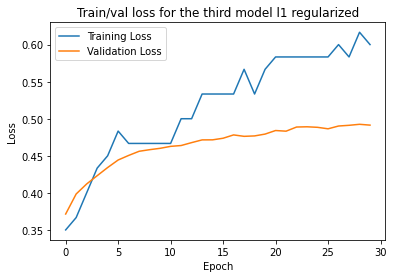

In [ ]:
plt.plot(model_reg.score()[0],label='Training Loss')
plt.plot(model_reg.score()[1],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/val loss for the third model l1 regularized')
plt.legend()
plt.show()

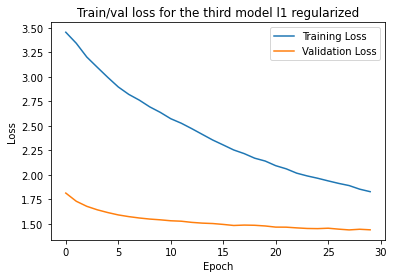

In [ ]:
plt.plot(model_reg.get_cost()[0],label='Training Loss')
plt.plot(model_reg.get_cost()[1],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/val loss for the third model l1 regularized')
plt.legend()
plt.show()

lambda= 0.05  gives the worse accuracy

In [ ]:
paramters=[Layer(units=256,input_units=3072, activation='relu',l1_regularization=0.05),
               Layer(units=256, activation='relu',l1_regularization=0.05),
               Layer(units=10, activation='softmax',l1_regularization=0.05)]
model_reg11 = Model_reg(paramters, batch_size=64,lr=0.01,
                random_state=4)

In [ ]:
model_reg11.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),patience=10,

          epochs=20
    )

Epoch 1 - Train_Loss:8.762811283258618  Val_Loss:1.648714288797877 Train_Acc:0.45 Val_Acc:0.4348
Epoch 2 - Train_Loss:7.349127579370548  Val_Loss:1.5701156858789587 Train_Acc:0.4666666666666667 Val_Acc:0.46464
Epoch 3 - Train_Loss:6.200103996668343  Val_Loss:1.5287508494708872 Train_Acc:0.5333333333333333 Val_Acc:0.47952
Epoch 4 - Train_Loss:5.290790522300401  Val_Loss:1.5055507195010125 Train_Acc:0.5666666666666667 Val_Acc:0.4844
Epoch 5 - Train_Loss:4.5713815283822505  Val_Loss:1.4931020587388608 Train_Acc:0.5333333333333333 Val_Acc:0.4872
Epoch 6 - Train_Loss:4.00184366854267  Val_Loss:1.4894692803636747 Train_Acc:0.55 Val_Acc:0.48608
Epoch 7 - Train_Loss:3.55954763041078  Val_Loss:1.4895459475091395 Train_Acc:0.5166666666666667 Val_Acc:0.488
Epoch 8 - Train_Loss:3.2275699113748617  Val_Loss:1.4903966319167647 Train_Acc:0.5333333333333333 Val_Acc:0.48704
Epoch 9 - Train_Loss:2.9755531838860234  Val_Loss:1.4976669389611743 Train_Acc:0.5333333333333333 Val_Acc:0.48272
Epoch 10 - Train

In [ ]:
pred = np.where(model_reg11.predict(X_test)==1)[1]
test = np.where(y_test==1)[1]
print(classification_report(test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.5839    0.4420    0.5031      1000
           1     0.5203    0.6790    0.5892      1000
           2     0.3604    0.3420    0.3509      1000
           3     0.3817    0.2550    0.3058      1000
           4     0.4004    0.3780    0.3889      1000
           5     0.3717    0.4720    0.4159      1000
           6     0.5412    0.5060    0.5230      1000
           7     0.5239    0.5480    0.5357      1000
           8     0.5088    0.6970    0.5882      1000
           9     0.5688    0.4300    0.4897      1000

    accuracy                         0.4749     10000
   macro avg     0.4761    0.4749    0.4690     10000
weighted avg     0.4761    0.4749    0.4690     10000



lambda= 0.1  also gives the worsen accuracy

In [ ]:
paramters=[Layer(units=256,input_units=3072, activation='relu',l1_regularization=0.1),
               Layer(units=256, activation='relu',l1_regularization=0.1),
               Layer(units=10, activation='softmax',l1_regularization=0.1)]
model_reg12 = Model_reg(paramters, batch_size=64,lr=0.01,
                random_state=4)

In [ ]:
model_reg12.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),patience=10,

          epochs=20
    )

Epoch 1 - Train_Loss:13.539024232923872  Val_Loss:1.9102243292681542 Train_Acc:0.3 Val_Acc:0.35232
Epoch 2 - Train_Loss:9.55320633861949  Val_Loss:1.8692885432147064 Train_Acc:0.3 Val_Acc:0.35824
Epoch 3 - Train_Loss:6.989766472666437  Val_Loss:1.8946582075048972 Train_Acc:0.3333333333333333 Val_Acc:0.34136
Epoch 4 - Train_Loss:5.447349752393753  Val_Loss:1.966976261817072 Train_Acc:0.3 Val_Acc:0.30208
Epoch 5 - Train_Loss:4.528934672530921  Val_Loss:2.027479692397431 Train_Acc:0.2833333333333333 Val_Acc:0.2752
Epoch 6 - Train_Loss:3.981123494177055  Val_Loss:2.0538054869381175 Train_Acc:0.3 Val_Acc:0.26384
Epoch 7 - Train_Loss:3.591224704940525  Val_Loss:2.0343323069382717 Train_Acc:0.3333333333333333 Val_Acc:0.2716
Epoch 8 - Train_Loss:3.2858086279152774  Val_Loss:1.9972114580702807 Train_Acc:0.31666666666666665 Val_Acc:0.28816
Epoch 9 - Train_Loss:3.039257504308547  Val_Loss:1.9618057813967387 Train_Acc:0.3 Val_Acc:0.30184
Epoch 10 - Train_Loss:2.842480148122051  Val_Loss:1.93884143

In [ ]:
pred = np.where(model_reg12.predict(X_test)==1)[1]
test = np.where(y_test==1)[1]
print(classification_report(test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.4456    0.2500    0.3203      1000
           1     0.2735    0.5770    0.3711      1000
           2     0.2803    0.0670    0.1082      1000
           3     0.2371    0.0230    0.0419      1000
           4     0.2996    0.2010    0.2406      1000
           5     0.2834    0.3650    0.3191      1000
           6     0.2859    0.5360    0.3729      1000
           7     0.3327    0.1650    0.2206      1000
           8     0.3612    0.5310    0.4300      1000
           9     0.3487    0.4160    0.3794      1000

    accuracy                         0.3131     10000
   macro avg     0.3148    0.3131    0.2804     10000
weighted avg     0.3148    0.3131    0.2804     10000



### Regularization L2

Regularization L2

We used different lambdas to investigate which one would give the best result since grid search is highly time consuming and we found that 0.01 is the best.

In [ ]:
class Layer:
    def __init__(self, units=None, input_units=None, activation=None, l2_regularization=0):
            self.input_units = input_units
            self.output_units = units
            self.regularization = l2_regularization
            assert activation in [None,'tanh','leaky_relu','relu','sigmoid','softmax'], 'Activation not recognized'
            self.activation = activation

class Model_regl2:
    def __init__(self, layers, batch_size,lr,max_norm=None,random_state=21):

        np.random.seed(random_state)
        self.batch_size=batch_size
        self.lr=lr
        self.parameters = {}
        self.activations = {}
        self.gradients = {}
        self.max_norm=max_norm
        self.regularization ={}
        self.cache = {}
        self.X = None
        self.Y = None
        self.cost_train=[]
        self.cost_vali=[]
        self.train_accuracy = []
        self.val_accuracy = []

        self.L = len(layers)

        for l in range(1,self.L+1):

            layer = layers[l-1]

            if layer.input_units:
                input_units = layer.input_units
                output_units = layer.output_units
            else:
                input_units  = previous_output_units
                output_units = layer.output_units

            # Apply Xavier Initialization
            #xavier_stddev = np.sqrt(2 / (input_units + output_units))
            self.parameters['W' + str(l)] = np.random.randn(output_units,input_units) * np.sqrt(2./input_units)
            self.parameters['b' + str(l)] = np.zeros((layer.output_units,1))

            self.activations['a' + str(l)] = layer.activation
            self.regularization['r' + str(l)] = layer.regularization

            previous_output_units = layer.output_units

    def forward(self, X):
      A_prev = X
      for l in range(1, self.L+1):
        Wl = self.parameters['W' + str(l)]
        bl = self.parameters['b' + str(l)]
        activation_fn = self.activations['a' + str(l)]

        Zl = np.dot(Wl, A_prev) + bl
        if activation_fn == 'tanh':
            Al = np.tanh(Zl)
        elif activation_fn == 'relu':
            Al = np.maximum(0, Zl)
        elif activation_fn == 'sigmoid':
            Al = 1 / (1 + np.exp(-Zl))
        elif activation_fn == 'softmax':
            exp_Zl = np.exp(Zl)
            Al = exp_Zl / np.sum(exp_Zl, axis=0, keepdims=True)
        elif activation_fn == 'leaky_relu':
            Al = np.maximum(0.01 * Zl, Zl)

        self.cache['Z' + str(l)] = Zl
        self.cache['A' + str(l)] = Al

        A_prev = Al

      return Al




    def loss(self, AL, Y):

        m = Y.shape[1] # number of examples
        regularization_term = 0
        for l in range(1,self.L+1):
            #regularization_term += self.regularization['r' + str(l)]*np.linalg.norm(self.parameters['W' + str(l)],ord='fro')**2
            regularization_term += self.regularization['r' + str(l)]*np.sum(np.square(self.parameters['W' + str(l)]))

        regularization_term /= (2*m)


        loss_each_example = -np.sum(Y * np.log(AL),axis=1)
        all_losses = np.sum(loss_each_example)
        cost = all_losses/m + regularization_term  # compute cost

        return cost

    def accuracy(self, A, Y):
        # calculate accuracy here

        predictions = np.argmax(A, axis=0)
        labels = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == labels)
        return accuracy

    def backward(self):
      m = self.X.shape[1] # number of examples

      # Retrieve all weights, biases, activations, and regularization parameters
      W, b, a, r = {}, {}, {}, {}
      A, Z = {}, {}
      for l in range(1, self.L+1):
          W[l] = self.parameters['W' + str(l)]
          b[l] = self.parameters['b' + str(l)]
          a[l] = self.activations['a' + str(l)]
          r[l] = self.regularization['r' + str(l)]

          A[l] = self.cache['A' + str(l)]
          Z[l] = self.cache['Z' + str(l)]
      A[0] = self.X

      # Backward propagation: calculate dW1, db1, ..., dWL, dbL
      dW, db, dZ = {}, {}, {}
      for l in reversed(range(1, self.L+1)):
          if a[l] == 'sigmoid' or a[l] == 'softmax':
              dZ[l] = A[l] - self.Y
          elif a[l] == 'tanh':
              dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (1 - np.square(Z[l])))
          elif a[l] == 'relu':
              dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (Z[l] > 0))
          elif a[l] == 'leaky_relu':
            dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), (Z[l] > 0) + (Z[l] <= 0) * 0.01)
          dW[l] = np.dot(dZ[l], A[l-1].T) / m  + r[l] * W[l] / m
          db[l] = np.sum(dZ[l], axis=1, keepdims=True) / m


      # Update weights and biases using gradient descent
      for l in range(1, self.L+1):
          W[l] -= self.lr * dW[l]
          b[l] -= self.lr * db[l]
          self.parameters['W' + str(l)] = W[l]
          self.parameters['b' + str(l)] = b[l]


    def get_batch(self, X, Y):

        np.random.seed(1)
        m = X.shape[1]
        mini_batches = []

        #shuffling the data
        permutation = list(np.random.permutation(X.shape[1]))
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[:, permutation]
        num_of_complete_batches = m // self.batch_size
        for i in range(num_of_complete_batches):
            mini_batch_X = X_shuffled[:,i* self.batch_size:(i+1)* self.batch_size]
            mini_batch_Y = Y_shuffled[:,i* self.batch_size:(i+1)* self.batch_size]
            mini_batch = (mini_batch_X,mini_batch_Y)
            mini_batches.append(mini_batch)

        #if there is incomplete batch
        if m % self.batch_size!= 0:

            mini_batch_X=X_shuffled[:,num_of_complete_batches* self.batch_size:num_of_complete_batches* self.batch_size + (m - self.batch_size *num_of_complete_batches)]
            mini_batch_Y=Y_shuffled[:,num_of_complete_batches* self.batch_size:num_of_complete_batches* self.batch_size + (m - self.batch_size *num_of_complete_batches)]
            mini_batch = (mini_batch_X,mini_batch_Y)
            mini_batches.append(mini_batch)
        return mini_batches


    def fit(self,
            X,
            Y,
            validation_data=None,
            epochs=100,
            patience=None):

        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values
        if isinstance(Y, (pd.core.frame.DataFrame,pd.core.series.Series)):
            Y = Y.values

        if X.ndim > 1:
            X = X.T
        else:
            X = np.expand_dims(X, axis=1)

        if Y.ndim > 1:
            Y = Y.T
        else:
            Y = np.expand_dims(Y, axis=0)

        self.full_Y = Y
        self.full_X = X

        mini_batches = self.get_batch(X, Y)

        if validation_data:
            X_val, Y_val = validation_data

            if isinstance(X_val, pd.core.frame.DataFrame):
                X_val = X_val.values
            if isinstance(Y_val, (pd.core.frame.DataFrame,pd.core.series.Series)):
                Y_val = Y_val.values

            if X_val.ndim > 1:
                X_val = X_val.T
            else:
                X_val = np.expand_dims(X_val, axis=1)

            if Y_val.ndim > 1:
                Y_val = Y_val.T
            else:
                Y_val = np.expand_dims(Y_val, axis=0)

        if patience:
            epoch_cache ={}
        cost_train=[]
        cost_vali=[]
        for i in range(0, epochs):

            for mini_batch in mini_batches:

                mini_batch_X, mini_batch_Y = mini_batch

                self.X = mini_batch_X
                self.Y = mini_batch_Y

                AL = self.forward(mini_batch_X)
                cost = self.loss(AL, mini_batch_Y)
                train_acc = self.accuracy(AL, mini_batch_Y)



                self.backward()

            if validation_data:
                AL_val = self.forward(X_val)
                cost_val = self.loss(AL_val, Y_val)

            # Print the cost and acc every epoch
            if validation_data:
                train_acc = self.accuracy(AL, mini_batch_Y)
                val_acc = self.accuracy(AL_val, Y_val)
                self.val_accuracy.append(val_acc)
                print(f"Epoch {i+1} - Train_Loss:{cost}  Val_Loss:{cost_val} Train_Acc:{train_acc} Val_Acc:{val_acc}")
                self.cost_train.append(cost)
                self.train_accuracy.append(train_acc)
                self.cost_vali.append(cost_val)

            else:

                self.cost_train.append(cost)
                print(f"Epoch {i+1} - Train_Loss:{cost}")

            if patience:
               if not epoch_cache or cost_val <= epoch_cache['best_loss']:
                    epoch_cache['best_loss'] = cost_val
                    epoch_cache['best_parameters'] = self.parameters
                    counter=0
               elif cost_val > epoch_cache['best_loss']:
                    counter += 1

               if counter == patience:
                    self.parameters = epoch_cache['best_parameters']
                    print(f"Early Stopping! Best Epoch {i+1-patience} - Val_Loss:{epoch_cache['best_loss']}")
                    break


    def predict(self, X):

        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values

        if X.ndim > 1:
            X = X.T
        else:
            X = np.expand_dims(X, axis=1)

        AL = self.forward(X)

        if AL.shape[0]==1:
            y_pred = AL[0]>0.5
        else:
            y_pred = (AL == np.max(AL,axis=0)).astype(bool).T
        y_pred = y_pred*1
        y_pred. astype('float32')
        return y_pred


    def get_cost(self,validation=True):
      if validation:
          return self.cost_train,self.cost_vali
      else:
        return self.cost_train
    def score(self,validation=True):
      if validation:
        return self.train_accuracy, self.val_accuracy
      else:
        return self.train_accuracy

def evaluate_acc(y, y_pred):
  acc=np.mean(np.argmax(y, axis=1) == np.argmax(y_pred, axis=1))
  print('The evaluation accuracy is ', acc)

In [ ]:
paramters=[Layer(units=256,input_units=3072, activation='relu',l2_regularization=0.01),
               Layer(units=256, activation='relu',l2_regularization=0.01),
               Layer(units=10, activation='softmax')]
model_regl2 = Model_regl2(paramters, batch_size=64,lr=0.01,
                random_state=4)

In [ ]:
model_regl2.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),patience=5,

          epochs=30)

Epoch 1 - Train_Loss:1.8763088937222956  Val_Loss:1.804431845153703 Train_Acc:0.3333333333333333 Val_Acc:0.36992
Epoch 2 - Train_Loss:1.8013772224015803  Val_Loss:1.719098621149189 Train_Acc:0.38333333333333336 Val_Acc:0.39944
Epoch 3 - Train_Loss:1.7297648752671397  Val_Loss:1.663505807549585 Train_Acc:0.38333333333333336 Val_Acc:0.41712
Epoch 4 - Train_Loss:1.665918996451701  Val_Loss:1.6275592574652482 Train_Acc:0.43333333333333335 Val_Acc:0.42584
Epoch 5 - Train_Loss:1.635290244247563  Val_Loss:1.595146217856799 Train_Acc:0.45 Val_Acc:0.43624
Epoch 6 - Train_Loss:1.604538029422356  Val_Loss:1.5703029927550123 Train_Acc:0.48333333333333334 Val_Acc:0.4468
Epoch 7 - Train_Loss:1.5592189318949135  Val_Loss:1.5505163453950144 Train_Acc:0.48333333333333334 Val_Acc:0.45216
Epoch 8 - Train_Loss:1.5374182405357317  Val_Loss:1.5372879990430672 Train_Acc:0.48333333333333334 Val_Acc:0.45832
Epoch 9 - Train_Loss:1.5244087479603041  Val_Loss:1.518798201173128 Train_Acc:0.48333333333333334 Val_Ac

In [ ]:
pred = np.where(model_regl2.predict(X_test)==1)[1]
test = np.where(y_test==1)[1]
print(classification_report(test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.5921    0.5430    0.5665      1000
           1     0.5407    0.7240    0.6191      1000
           2     0.4625    0.3270    0.3831      1000
           3     0.3603    0.2850    0.3183      1000
           4     0.4388    0.4480    0.4433      1000
           5     0.3885    0.4790    0.4290      1000
           6     0.5135    0.6090    0.5572      1000
           7     0.7240    0.4170    0.5292      1000
           8     0.5186    0.7380    0.6092      1000
           9     0.5799    0.4680    0.5180      1000

    accuracy                         0.5038     10000
   macro avg     0.5119    0.5038    0.4973     10000
weighted avg     0.5119    0.5038    0.4973     10000



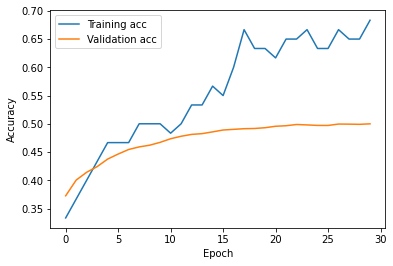

In [ ]:
plt.plot(model_regl2.score()[0],label='Training acc')
plt.plot(model_regl2.score()[1],label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/val accuracy for the third model l2 regularized')

plt.legend()
plt.show()

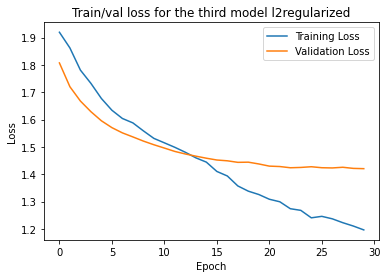

In [ ]:
plt.plot(model_regl2.get_cost()[0],label='Training Loss')
plt.plot(model_regl2.get_cost()[1],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/val loss for the third model l2regularized')
plt.legend()
plt.show()

In [ ]:
paramters=[Layer(units=256,input_units=3072, activation='relu',l2_regularization=0.01),
               Layer(units=256, activation='relu',l2_regularization=0.01),
               Layer(units=10, activation='softmax')]
model_regl2 = Model_regl2(paramters, batch_size=64,lr=0.01,
                random_state=0)

In [ ]:
model_regl2.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),patience=5,

          epochs=30)

Epoch 1 - Train_Loss:1.7926006916360442  Val_Loss:1.8031573828915843 Train_Acc:0.38333333333333336 Val_Acc:0.36744
Epoch 2 - Train_Loss:1.7116205241842604  Val_Loss:1.7100584359892939 Train_Acc:0.4166666666666667 Val_Acc:0.40224
Epoch 3 - Train_Loss:1.6466253002913651  Val_Loss:1.658644250431639 Train_Acc:0.45 Val_Acc:0.41792
Epoch 4 - Train_Loss:1.6093400372639084  Val_Loss:1.6190964710120916 Train_Acc:0.45 Val_Acc:0.42952
Epoch 5 - Train_Loss:1.5707182809388809  Val_Loss:1.5893064750788755 Train_Acc:0.43333333333333335 Val_Acc:0.44016
Epoch 6 - Train_Loss:1.5378425830606621  Val_Loss:1.5663091537588487 Train_Acc:0.45 Val_Acc:0.44824
Epoch 7 - Train_Loss:1.519850160750666  Val_Loss:1.5441688931696473 Train_Acc:0.48333333333333334 Val_Acc:0.45488
Epoch 8 - Train_Loss:1.4913098118679355  Val_Loss:1.524667112343886 Train_Acc:0.48333333333333334 Val_Acc:0.4632
Epoch 9 - Train_Loss:1.4642339769037878  Val_Loss:1.50884497083852 Train_Acc:0.5166666666666667 Val_Acc:0.4664
Epoch 10 - Train_Lo

In [ ]:
pred = np.where(model_regl2.predict(X_test)==1)[1]
test = np.where(y_test==1)[1]
print(classification_report(test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.5609    0.5570    0.5590      1000
           1     0.6195    0.6740    0.6456      1000
           2     0.4652    0.3210    0.3799      1000
           3     0.3763    0.2540    0.3033      1000
           4     0.4470    0.4430    0.4450      1000
           5     0.3816    0.4930    0.4302      1000
           6     0.4809    0.6530    0.5539      1000
           7     0.6797    0.4690    0.5550      1000
           8     0.5368    0.7440    0.6236      1000
           9     0.6308    0.5280    0.5749      1000

    accuracy                         0.5136     10000
   macro avg     0.5179    0.5136    0.5070     10000
weighted avg     0.5179    0.5136    0.5070     10000



In [ ]:
y_pred=model_regl2.predict(X_test)

In [ ]:
evaluate_acc(y_test,y_pred)

The evaluation accuracy is  0.5136


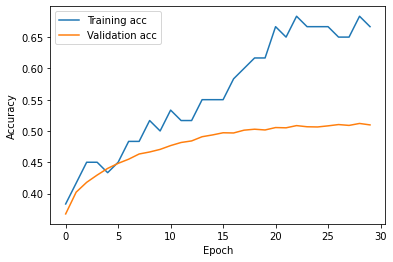

In [ ]:
plt.plot(model_regl2.score()[0],label='Training acc')
plt.plot(model_regl2.score()[1],label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/val accuracy for the third model l2regularized')

plt.legend()
plt.show()

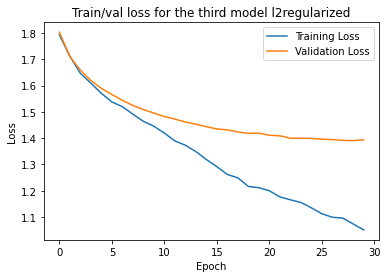

In [ ]:
plt.plot(model_regl2.get_cost()[0],label='Training Loss')
plt.plot(model_regl2.get_cost()[1],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/val loss for the third model l2regularized')
plt.legend()
plt.show()

Lambda 0.05 for L2

In [ ]:
paramters=[Layer(units=256,input_units=3072, activation='relu',l2_regularization=0.05),
               Layer(units=256, activation='relu',l2_regularization=0.05),
               Layer(units=10, activation='softmax')]
model_regl2 = Model_regl2(paramters, batch_size=64,lr=0.01,
                random_state=4)

In [ ]:
model_regl2.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),patience=5,

          epochs=30)

Epoch 1 - Train_Loss:2.21064088103078  Val_Loss:1.8118146439755163 Train_Acc:0.36666666666666664 Val_Acc:0.36984
Epoch 2 - Train_Loss:2.1432995372687413  Val_Loss:1.7227474098653672 Train_Acc:0.35 Val_Acc:0.398
Epoch 3 - Train_Loss:2.0771986152504476  Val_Loss:1.6673132611879176 Train_Acc:0.38333333333333336 Val_Acc:0.41544
Epoch 4 - Train_Loss:2.02661719605312  Val_Loss:1.6279951079185202 Train_Acc:0.4 Val_Acc:0.42704
Epoch 5 - Train_Loss:1.9698474907023735  Val_Loss:1.600747629195592 Train_Acc:0.4166666666666667 Val_Acc:0.43632
Epoch 6 - Train_Loss:1.9338809518856164  Val_Loss:1.5761822575740079 Train_Acc:0.4166666666666667 Val_Acc:0.44376
Epoch 7 - Train_Loss:1.8971852489296528  Val_Loss:1.5520779722892324 Train_Acc:0.43333333333333335 Val_Acc:0.45216
Epoch 8 - Train_Loss:1.8652006843314108  Val_Loss:1.5347465971763166 Train_Acc:0.45 Val_Acc:0.45864
Epoch 9 - Train_Loss:1.8423127320153103  Val_Loss:1.521610943027151 Train_Acc:0.48333333333333334 Val_Acc:0.4624
Epoch 10 - Train_Loss:

In [ ]:
pred = np.where(model_regl2.predict(X_test)==1)[1]
test = np.where(y_test==1)[1]
print(classification_report(test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.5546    0.5790    0.5665      1000
           1     0.5605    0.7040    0.6241      1000
           2     0.4401    0.2680    0.3331      1000
           3     0.3641    0.2640    0.3061      1000
           4     0.4344    0.4770    0.4547      1000
           5     0.3771    0.4740    0.4200      1000
           6     0.5205    0.6210    0.5663      1000
           7     0.7015    0.4300    0.5332      1000
           8     0.5084    0.7550    0.6076      1000
           9     0.6069    0.4370    0.5081      1000

    accuracy                         0.5009     10000
   macro avg     0.5068    0.5009    0.4920     10000
weighted avg     0.5068    0.5009    0.4920     10000



Lmbda 0.1 show the worse results

In [ ]:
paramters=[Layer(units=256,input_units=3072, activation='relu',l2_regularization=0.1),
               Layer(units=256, activation='relu',l2_regularization=0.1),
               Layer(units=10, activation='softmax')]
model_regl2 = Model_regl2(paramters, batch_size=64,lr=0.01,
                random_state=4)

In [ ]:
model_regl2.fit(X_train,
          y_train,
          validation_data=(X_val,y_val),patience=5,

          epochs=30)

Epoch 1 - Train_Loss:2.612075493427348  Val_Loss:1.8126123390031437 Train_Acc:0.36666666666666664 Val_Acc:0.36936
Epoch 2 - Train_Loss:2.544236839448475  Val_Loss:1.7247613638430797 Train_Acc:0.3333333333333333 Val_Acc:0.3988
Epoch 3 - Train_Loss:2.4579560814180113  Val_Loss:1.6720013618009757 Train_Acc:0.38333333333333336 Val_Acc:0.40984
Epoch 4 - Train_Loss:2.381795066275315  Val_Loss:1.6374753146118133 Train_Acc:0.43333333333333335 Val_Acc:0.42144
Epoch 5 - Train_Loss:2.332026118961544  Val_Loss:1.6030135641911982 Train_Acc:0.45 Val_Acc:0.43496
Epoch 6 - Train_Loss:2.275391807295125  Val_Loss:1.5821542861478972 Train_Acc:0.4666666666666667 Val_Acc:0.44184
Epoch 7 - Train_Loss:2.2258774012093  Val_Loss:1.5590099745917672 Train_Acc:0.45 Val_Acc:0.4532
Epoch 8 - Train_Loss:2.188843606841158  Val_Loss:1.5424324543872796 Train_Acc:0.4666666666666667 Val_Acc:0.4572
Epoch 9 - Train_Loss:2.1627655443573435  Val_Loss:1.5298330223651384 Train_Acc:0.48333333333333334 Val_Acc:0.46208
Epoch 10 -

In [ ]:
pred = np.where(model_regl2.predict(X_test)==1)[1]
test = np.where(y_test==1)[1]
print(classification_report(test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.5638    0.5570    0.5604      1000
           1     0.5697    0.7190    0.6357      1000
           2     0.4560    0.2800    0.3470      1000
           3     0.3832    0.2920    0.3314      1000
           4     0.4099    0.5140    0.4561      1000
           5     0.3920    0.4480    0.4181      1000
           6     0.5173    0.5990    0.5551      1000
           7     0.7026    0.4370    0.5388      1000
           8     0.5030    0.7560    0.6041      1000
           9     0.6254    0.4340    0.5124      1000

    accuracy                         0.5036     10000
   macro avg     0.5123    0.5036    0.4959     10000
weighted avg     0.5123    0.5036    0.4959     10000



## Task 3.4: Non normalized data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)

X_train_nonorm = np.reshape(x_train,(50000,3072))
X_test_nonorm = np.reshape(x_test,(10000,3072))
X_train_nonorm = X_train_nonorm.astype('float32')
X_test_nonorm = X_test_nonorm.astype('float32')



In [ ]:
X_train_no, X_val_no, y_train, y_val = train_test_split(X_train_nonorm,y_train,random_state=42,stratify=y_train)


In [ ]:

twohidden_layer_parameters=[Layer(units=256,input_units=3072, activation='relu'),
               Layer(units=256, activation='relu'),
               Layer(units=10, activation='softmax')]
model3 = Model(twohidden_layer_parameters,  batch_size=128,lr=0.01,
               random_state=10)


In [ ]:
 model3.fit(X_train_no,
          y_train,
          validation_data=(X_val_no,y_val),patience=10,

          epochs=100
          )

<ipython-input-121-3a7cf72c7b2e>:86: RuntimeWarning: divide by zero encountered in log
  loss_each_example = -np.sum(Y * np.log(AL),axis=1)
<ipython-input-121-3a7cf72c7b2e>:86: RuntimeWarning: invalid value encountered in multiply
  loss_each_example = -np.sum(Y * np.log(AL),axis=1)
<ipython-input-121-3a7cf72c7b2e>:66: RuntimeWarning: overflow encountered in exp
  exp_Zl = np.exp(Zl)
<ipython-input-121-3a7cf72c7b2e>:67: RuntimeWarning: invalid value encountered in true_divide
  Al = exp_Zl / np.sum(exp_Zl, axis=0, keepdims=True)


Epoch 1 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.08064516129032258 Val_Acc:0.1
Epoch 2 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.08064516129032258 Val_Acc:0.1
Epoch 3 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.08064516129032258 Val_Acc:0.1
Epoch 4 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.08064516129032258 Val_Acc:0.1
Epoch 5 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.08064516129032258 Val_Acc:0.1
Epoch 6 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.08064516129032258 Val_Acc:0.1
Epoch 7 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.08064516129032258 Val_Acc:0.1
Epoch 8 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.08064516129032258 Val_Acc:0.1
Epoch 9 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.08064516129032258 Val_Acc:0.1
Epoch 10 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.08064516129032258 Val_Acc:0.1
Epoch 11 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.08064516129032258 Val_Acc:0.1
Epoch 12 - Train_Loss:nan  Val_Loss:nan Train_Acc:0.08064516129032258 Val_Acc:0.1
Epoch 13 - Train_Loss:nan

KeyboardInterrupt: ignored

## Task 3.5: CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        147520    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train,y_train, epochs=10,
                    validation_data=(x_test,y_test))

Epoch 1/10
1563/1563 [==============================] - 402s 256ms/step - loss: 1.6122 - accuracy: 0.4123 - val_loss: 1.3174 - val_accuracy: 0.5253
Epoch 2/10
1563/1563 [==============================] - 385s 247ms/step - loss: 1.2602 - accuracy: 0.5512 - val_loss: 1.1782 - val_accuracy: 0.5850
Epoch 3/10
1563/1563 [==============================] - 381s 244ms/step - loss: 1.1261 - accuracy: 0.6032 - val_loss: 1.0926 - val_accuracy: 0.6148
Epoch 4/10
1563/1563 [==============================] - 375s 240ms/step - loss: 1.0353 - accuracy: 0.6368 - val_loss: 1.0807 - val_accuracy: 0.6157
Epoch 5/10
1563/1563 [==============================] - 375s 240ms/step - loss: 0.9684 - accuracy: 0.6596 - val_loss: 1.0382 - val_accuracy: 0.6376
Epoch 6/10
1563/1563 [==============================] - 371s 238ms/step - loss: 0.9152 - accuracy: 0.6794 - val_loss: 0.9648 - val_accuracy: 0.6615
Epoch 7/10
1563/1563 [==============================] - 364s 233ms/step - loss: 0.8715 - accuracy: 0.6940 - val_

Result for model with 256 unit layer

313/313 - 15s - loss: 0.9094 - accuracy: 0.6895 - 15s/epoch - 48ms/step


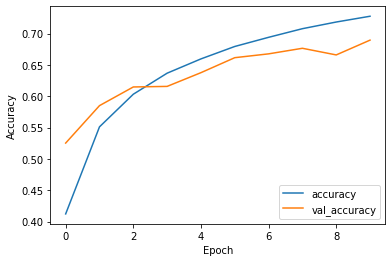

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/val accuracy CNN')

plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

Result for model with 32 unit layer

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train,y_train, epochs=10,
                    validation_data=(x_test,y_test))

313/313 - 6s - loss: 0.8675 - accuracy: 0.7098 - 6s/epoch - 18ms/step


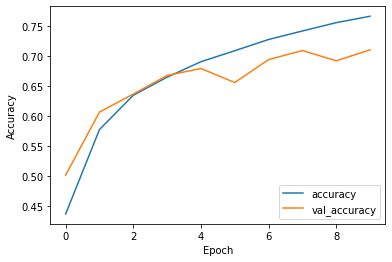

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/val accuracy CNN')

plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

## Task 3.6: CNN pretrained

### ResNet 50

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Define the transforms for the data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:

# Load the CIFAR-10 data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# Load the pre-trained ResNet50 model
resnet50 = torchvision.models.resnet50(pretrained=True)

# Modify the output layer for CIFAR-10 classification
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 10)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)


In [ ]:
# Train the model
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    resnet50.train()
    for data in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{10}'):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss_train = running_loss / len(trainloader)
    epoch_acc_train = correct / total
    train_loss.append(epoch_loss_train)
    train_acc.append(epoch_acc_train)

    running_loss = 0.0
    correct = 0
    total = 0
    resnet50.eval()
    with torch.no_grad():
        for data in tqdm(testloader, desc=f'Test Epoch {epoch + 1}/{10}'):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(testloader)
        epoch_acc = correct / total
        test_loss.append(epoch_loss)
        test_acc.append(epoch_acc)

    print(f'Epoch {epoch+1}/{10} - '
          f'Train Loss: {epoch_loss_train:.4f} - Train Acc: {epoch_acc_train:.4f} - '
          f'Test Loss: {epoch_loss:.4f} - Test Acc: {epoch_acc:.4f}')

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Test Epoch 1/10: 100%|██████████| 79/79 [00:03<00:00, 19.77it/s]


Epoch 1/10 - Train Loss: 1.2762 - Train Acc: 0.5522 - Test Loss: 0.8403 - Test Acc: 0.6999


Test Epoch 2/10: 100%|██████████| 79/79 [00:04<00:00, 17.45it/s]


Epoch 2/10 - Train Loss: 0.7720 - Train Acc: 0.7290 - Test Loss: 0.6491 - Test Acc: 0.7734


Test Epoch 3/10: 100%|██████████| 79/79 [00:04<00:00, 17.25it/s]


Epoch 3/10 - Train Loss: 0.6385 - Train Acc: 0.7775 - Test Loss: 0.5775 - Test Acc: 0.8062


Test Epoch 4/10: 100%|██████████| 79/79 [00:04<00:00, 18.73it/s]


Epoch 4/10 - Train Loss: 0.5579 - Train Acc: 0.8057 - Test Loss: 0.5348 - Test Acc: 0.8213


Test Epoch 5/10: 100%|██████████| 79/79 [00:03<00:00, 23.42it/s]


Epoch 5/10 - Train Loss: 0.5025 - Train Acc: 0.8233 - Test Loss: 0.5014 - Test Acc: 0.8297


Test Epoch 6/10: 100%|██████████| 79/79 [00:03<00:00, 23.39it/s]


Epoch 6/10 - Train Loss: 0.4582 - Train Acc: 0.8393 - Test Loss: 0.4785 - Test Acc: 0.8379


Test Epoch 7/10: 100%|██████████| 79/79 [00:03<00:00, 23.90it/s]


Epoch 7/10 - Train Loss: 0.4180 - Train Acc: 0.8536 - Test Loss: 0.4716 - Test Acc: 0.8426


Test Epoch 8/10: 100%|██████████| 79/79 [00:03<00:00, 23.62it/s]


Epoch 8/10 - Train Loss: 0.3911 - Train Acc: 0.8628 - Test Loss: 0.4648 - Test Acc: 0.8461


Test Epoch 9/10: 100%|██████████| 79/79 [00:04<00:00, 18.23it/s]


Epoch 9/10 - Train Loss: 0.3591 - Train Acc: 0.8722 - Test Loss: 0.4662 - Test Acc: 0.8503


Test Epoch 10/10: 100%|██████████| 79/79 [00:04<00:00, 17.75it/s]


Epoch 10/10 - Train Loss: 0.3390 - Train Acc: 0.8798 - Test Loss: 0.4551 - Test Acc: 0.8473


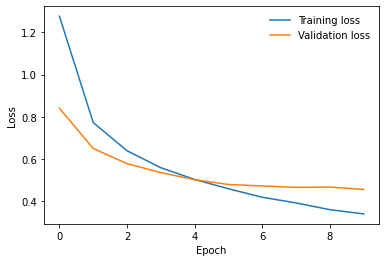

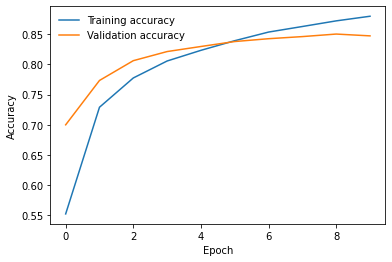

In [ ]:



# Plot the learning curves
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/val loss ResNet 50')
plt.show()

plt.plot(train_acc, label='Training accuracy')
plt.plot(test_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/val accuracy Resnet50')

plt.show()


### DenseNet 201

In [ ]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def preprocess_data(X, Y):
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [ ]:
# load the Cifar10 dataset
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()
# preprocess the data
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
# initialized weights
initializer = K.initializers.he_normal()
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to pretrained size
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
model = K.applications.DenseNet201(include_top=False,
                                   weights='imagenet',
                                   input_tensor=resized_images,
                                   input_shape=(224, 224, 3),
                                   pooling='max',
                                   classes=1000)
# make the weights and biases of the model non-trainable by "freezing" each layer of the DenseNet201 network
for layer in model.layers:
    layer.trainable = False
output = model.layers[-1].output
# reshape the output feature map
flatten = K.layers.Flatten()
output = flatten(output)
layer_256 = K.layers.Dense(units=256,
                           activation='relu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(output)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=10,
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=input_tensor, outputs=output)

74836368/74836368 [==============================] - 1s 0us/step


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

In [ ]:
# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights (uploaded)
checkpoint = K.callbacks.ModelCheckpoint('cifar10.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [ ]:
train_steps_per_epoch = x_train.shape[0] // 32
val_steps_per_epoch = x_test.shape[0] // 32
history = model.fit(x_train,y_train, batch_size=32,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data= [x_test, y_test],
                    epochs=20,
                    shuffle=True,
                    callbacks=[lr_reduce, early_stop, checkpoint],
                    verbose=1)

Epoch 1/20
  21/1562 [..............................] - ETA: 3:51:27 - loss: 10.7418 - accuracy: 0.1384

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()